In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

## Set Plotting Defaults

In [2]:
import logging
import os

import matplotlib
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from replay_trajectory_classification.misc import STATE_COLORS, TRANSITION_TO_CATEGORY

# Set background and fontsize
rc_params = {
    'pdf.fonttype': 42, # Make fonts editable in Adobe Illustrator
    'ps.fonttype': 42, # Make fonts editable in Adobe Illustrator
    'axes.labelcolor': '#222222',
    'text.color': '#222222',
    }
sns.set(style="white", context='paper', rc=rc_params,
        font_scale=1.3)

# Make analysis reproducible
np.random.seed(0)

# Enable logging
logging.basicConfig(level=logging.INFO)

## Simulate Clusterless Data

(0.0, 349.999)

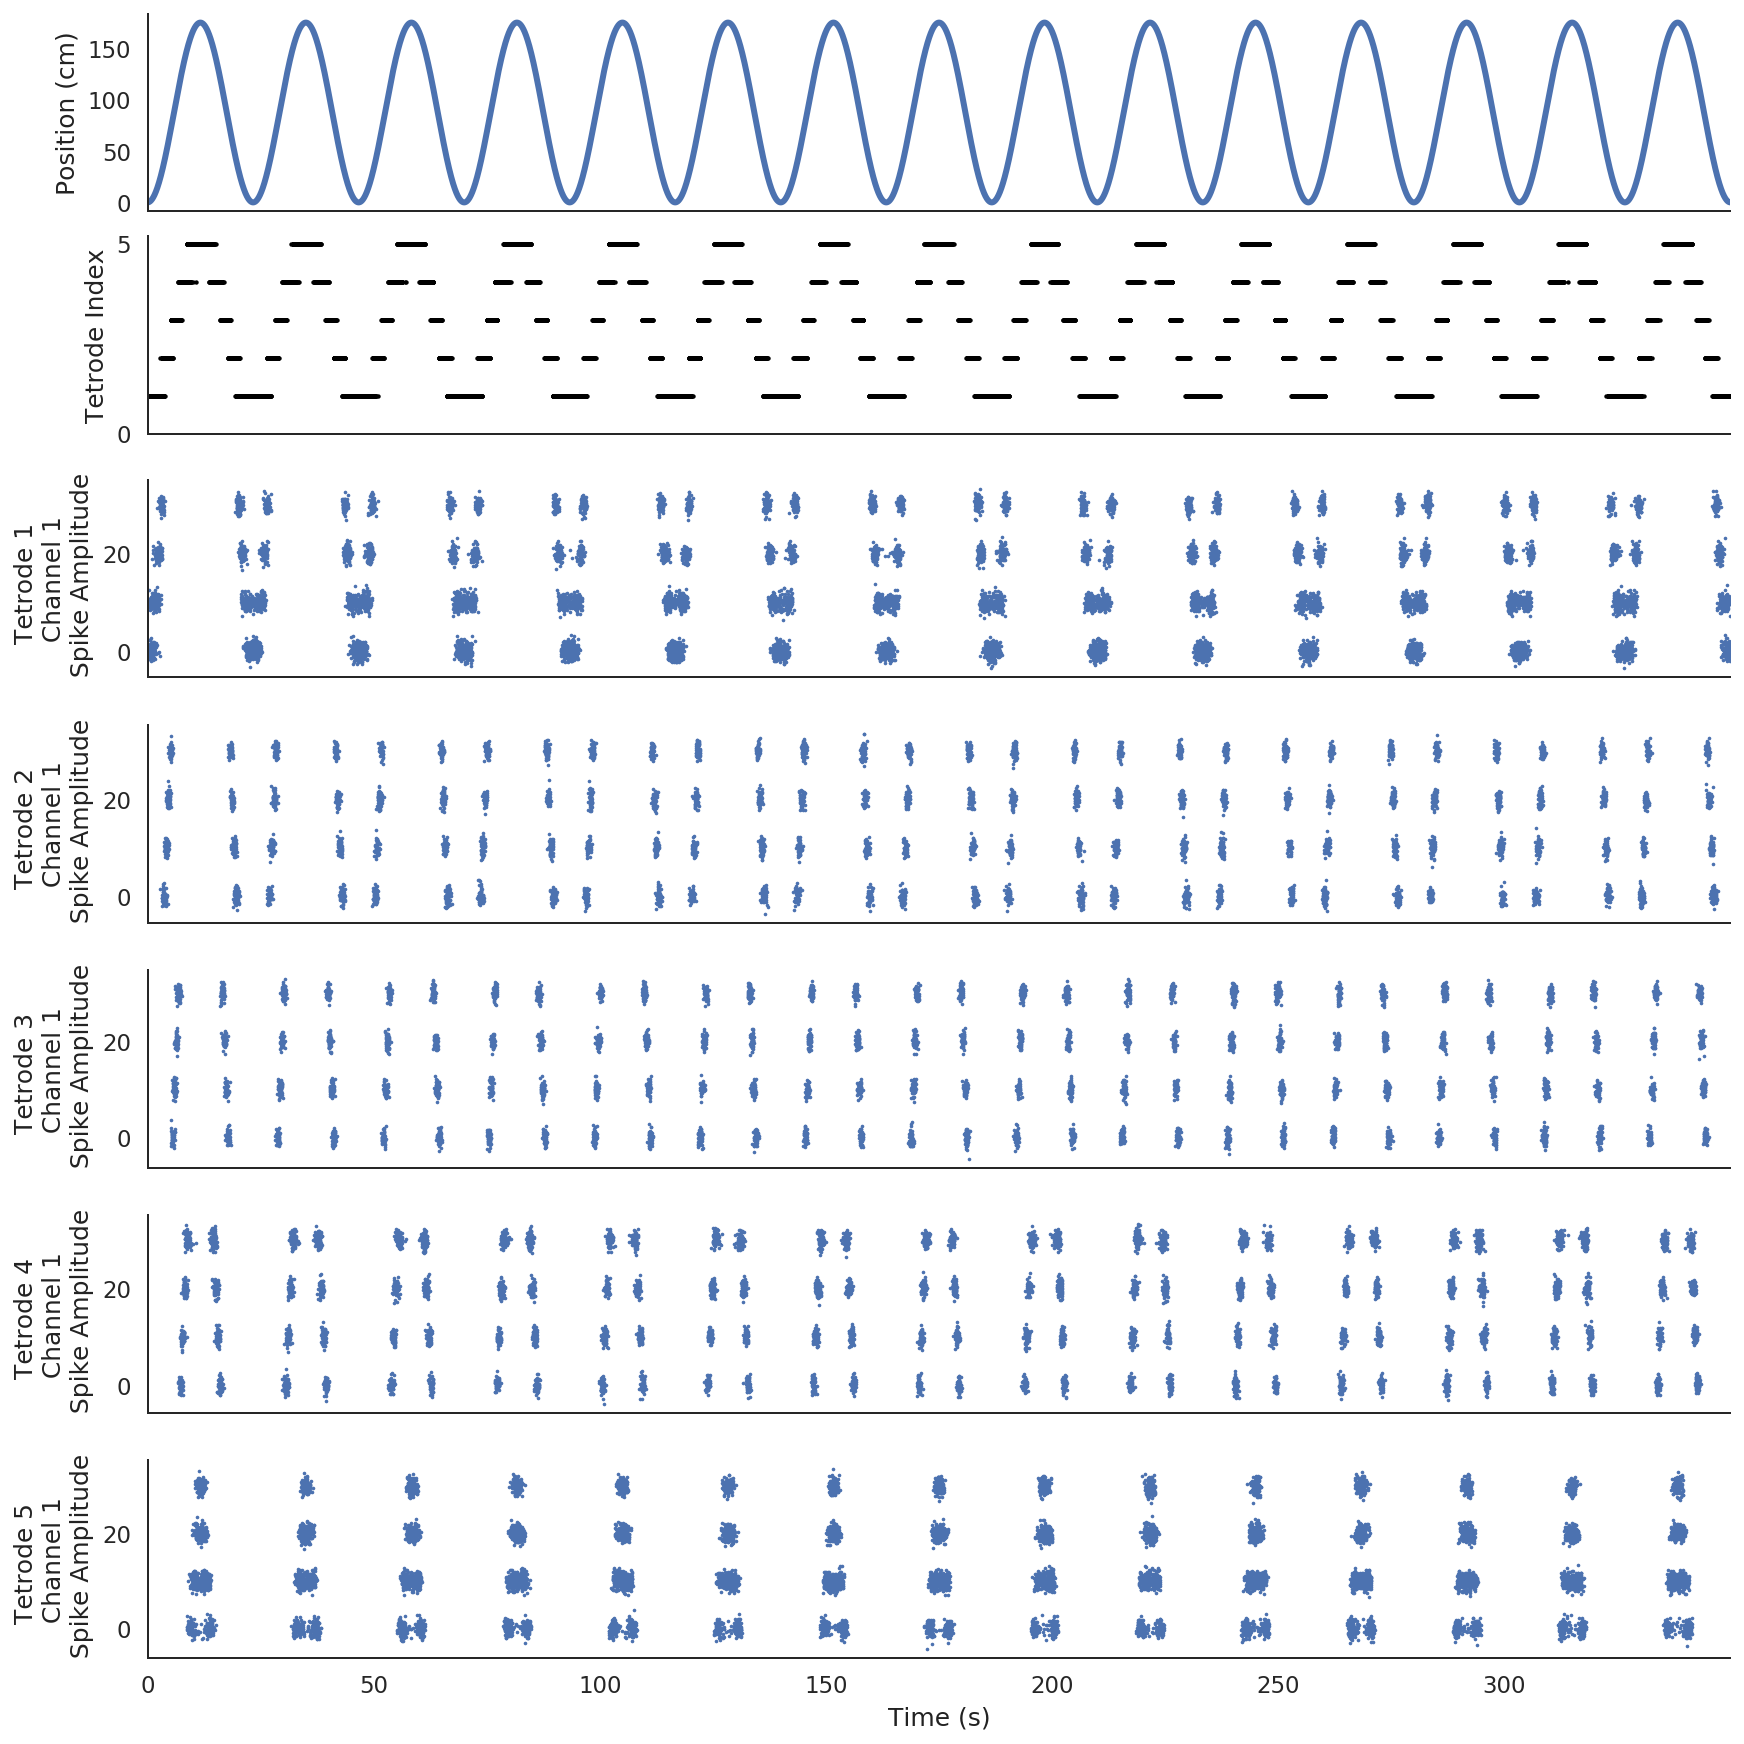

In [3]:
from replay_trajectory_classification.clusterless_simulation import make_simulated_run_data

(time, linear_distance, sampling_frequency,
 multiunits, multiunits_spikes) = make_simulated_run_data()

spike_ind, neuron_ind = np.nonzero(multiunits_spikes)

fig, axes = plt.subplots(7, 1, figsize=(12, 12), constrained_layout=True, sharex=True)
axes[0].plot(time, linear_distance, linewidth=3)
axes[0].set_ylabel('Position (cm)')

axes[1].scatter(time[spike_ind], neuron_ind + 1, color='black', s=2)
axes[1].set_yticks((0, multiunits_spikes.shape[1]))
axes[1].set_ylabel('Tetrode Index')

for tetrode_ind in range(multiunits.shape[-1]):
    axes[2 + tetrode_ind].scatter(time, multiunits[:, 0, tetrode_ind], s=1)
    axes[2 + tetrode_ind].set_ylabel(f'Tetrode {tetrode_ind + 1} \n Channel 1 \n Spike Amplitude')

sns.despine()
axes[-1].set_xlabel('Time (s)')
axes[-1].set_xlim((time.min(), time.max()))

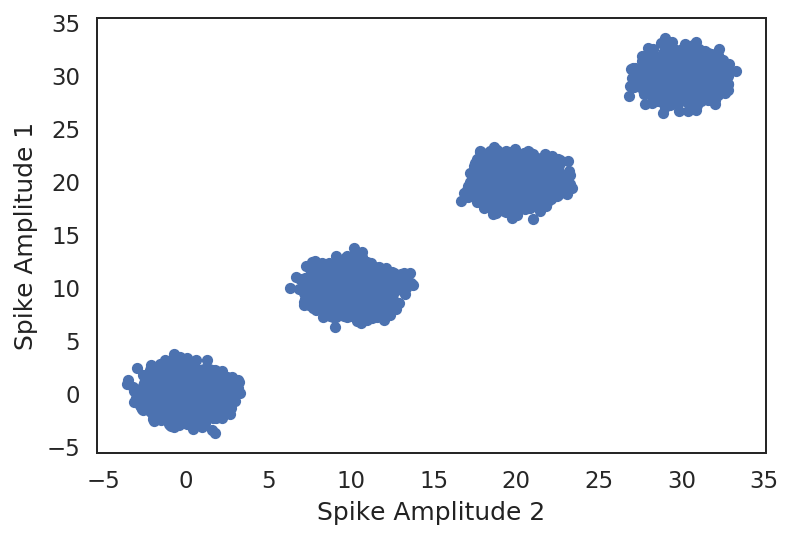

In [4]:
plt.scatter(multiunits[:, 0, 0], multiunits[:, 1, 0])
plt.ylabel('Spike Amplitude 1')
plt.xlabel('Spike Amplitude 2');

## Fit Clusterless Classifier

In [5]:
from replay_trajectory_classification import ClusterlessClassifier
from replay_trajectory_classification.state_transition import estimate_movement_var
from replay_trajectory_classification.misc import NumbaKDE

movement_var = estimate_movement_var(linear_distance, sampling_frequency)
model = NumbaKDE
model_kwargs = {
    'bandwidth': np.array([1.0, 1.0, 1.0, 1.0, 12.5, 12.5])
    }



classifier = ClusterlessClassifier(movement_var=movement_var,
                                   replay_speed=120,
                                   place_bin_size=np.sqrt(movement_var),
                                   model=model,
                                   model_kwargs=model_kwargs)
classifier.fit(linear_distance, multiunits)

/home/edeno/miniconda3/envs/replay_trajectory_classification/lib/python3.6/site-packages/distributed/dashboard/core.py:79: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn("\n" + msg)
INFO:replay_trajectory_classification.classifier:Fitting initial conditions...
INFO:replay_trajectory_classification.classifier:Fitting state transition...
INFO:replay_trajectory_classification.classifier:Fitting multiunits...


ClusterlessClassifier(continuous_transition_types=[['random_walk', 'uniform',
                                                    'identity'],
                                                   ['uniform', 'uniform',
                                                    'uniform'],
                                                   ['random_walk', 'uniform',
                                                    'identity']],
                      discrete_transition_diag=0.99,
                      discrete_transition_type='strong_diagonal',
                      infer_track_interior=True,
                      initial_conditions_type='uniform_on_track',
                      model=<class 'replay_trajectory_classification.misc.NumbaKDE'>,
                      model_kwargs={'bandwidth': array([ 1. ,  1. ,  1. ,  1. , 12.5, 12.5])},
                      movement_var=0.27758420829876046,
                      occupancy_kwargs={'bandwidth': array([ 1. ,  1. ,  1. ,  1. , 12.5, 12.5])},
     

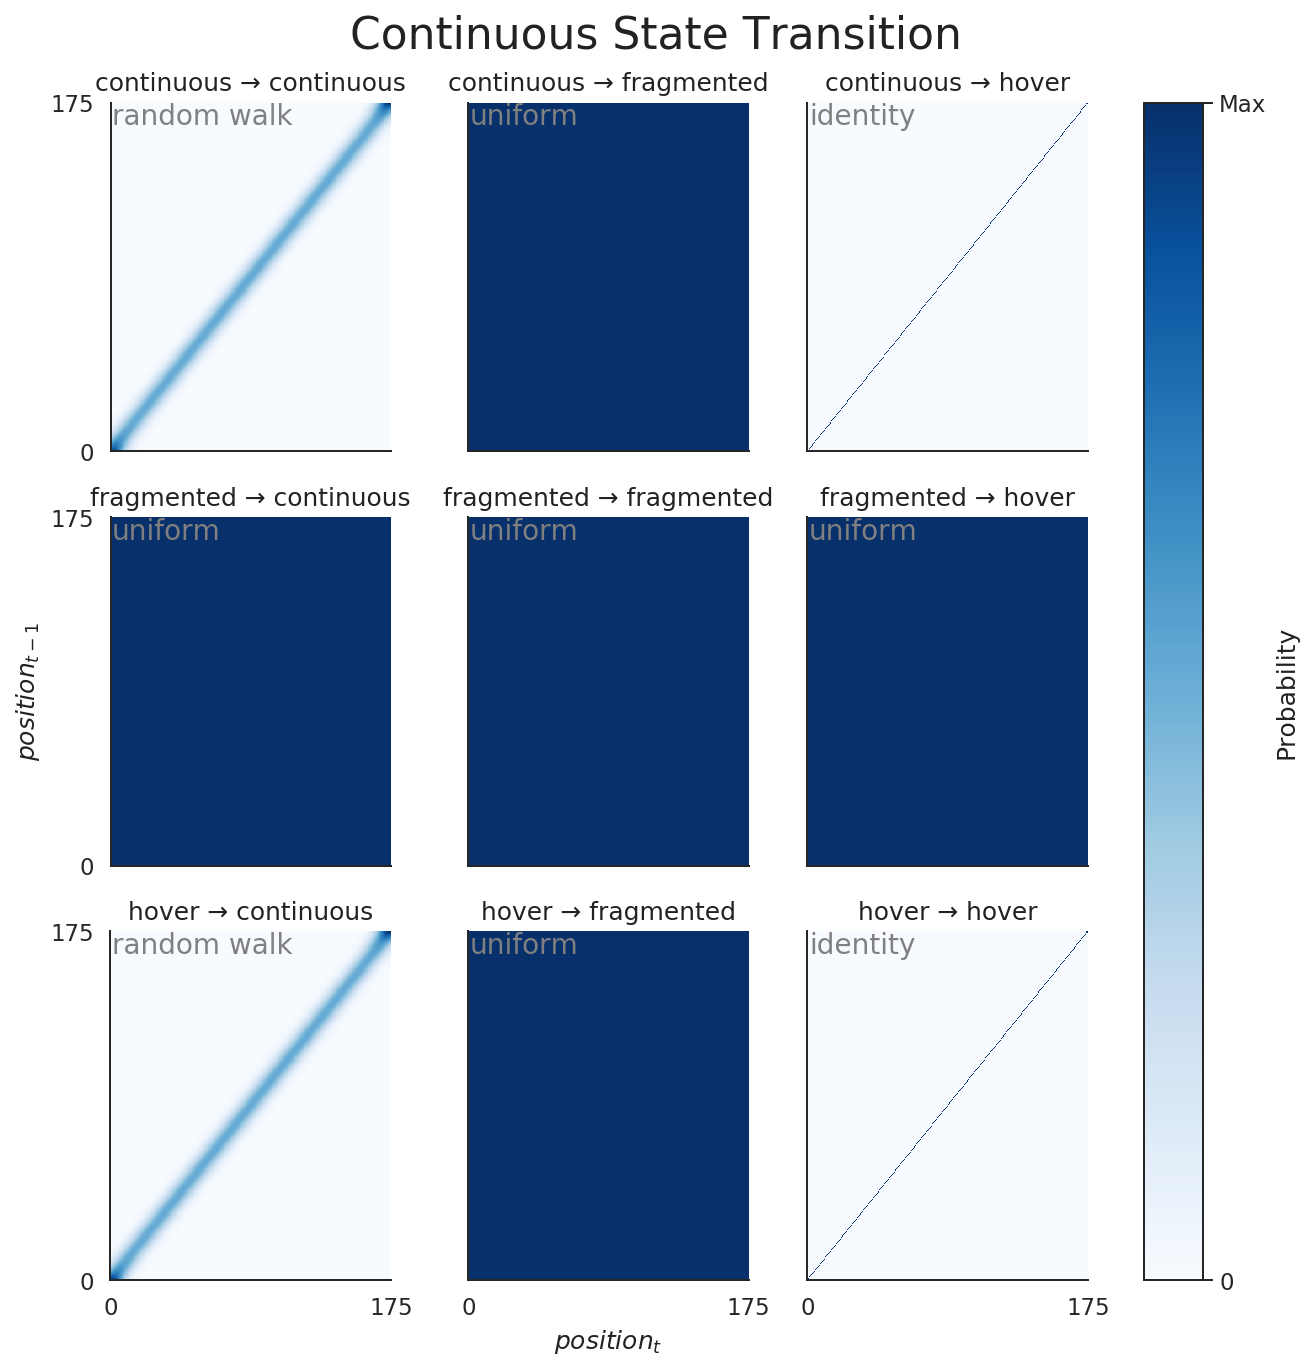

In [6]:
fig, axes = plt.subplots(3, 3, figsize=(9, 9),
                         sharex=True, sharey=True,
                         constrained_layout=True)
continuous_transition_types = np.asarray(classifier.continuous_transition_types)
x, y = np.meshgrid(classifier.place_bin_edges_, classifier.place_bin_edges_)
state_names = ['continuous', 'fragmented', 'hover']
bin_min, bin_max = linear_distance.min(), linear_distance.max()

for j in range(3):
    for k in range(3):
        im = axes[j, k].pcolormesh(x, y, classifier.continuous_state_transition_[j, k], cmap='Blues',
                                   vmin=0.0, vmax=classifier.continuous_state_transition_[j, k].max())
        axes[j, k].text(1, 175, continuous_transition_types[j, k].replace('_', ' '), color='grey',
                        va='top', fontsize=14)
        axes[j, k].set_title(f'{state_names[j]} → {state_names[k]}')
        axes[j, k].set_xticks((bin_min, bin_max))
        axes[j, k].set_yticks((bin_min, bin_max))
        
plt.xlim((bin_min, bin_max))
plt.ylim((bin_min, bin_max))
axes[1, 0].set_ylabel(r'$position_{t-1}$')
axes[-1, 1].set_xlabel(r'$position_{t}$')
plt.suptitle('Continuous State Transition', y=1.04, fontsize=22)
cbar = fig.colorbar(im, ax=axes.ravel().tolist(), ticks=[0, 1], label='Probability')
cbar.ax.set_yticklabels(['0', 'Max'])
sns.despine()

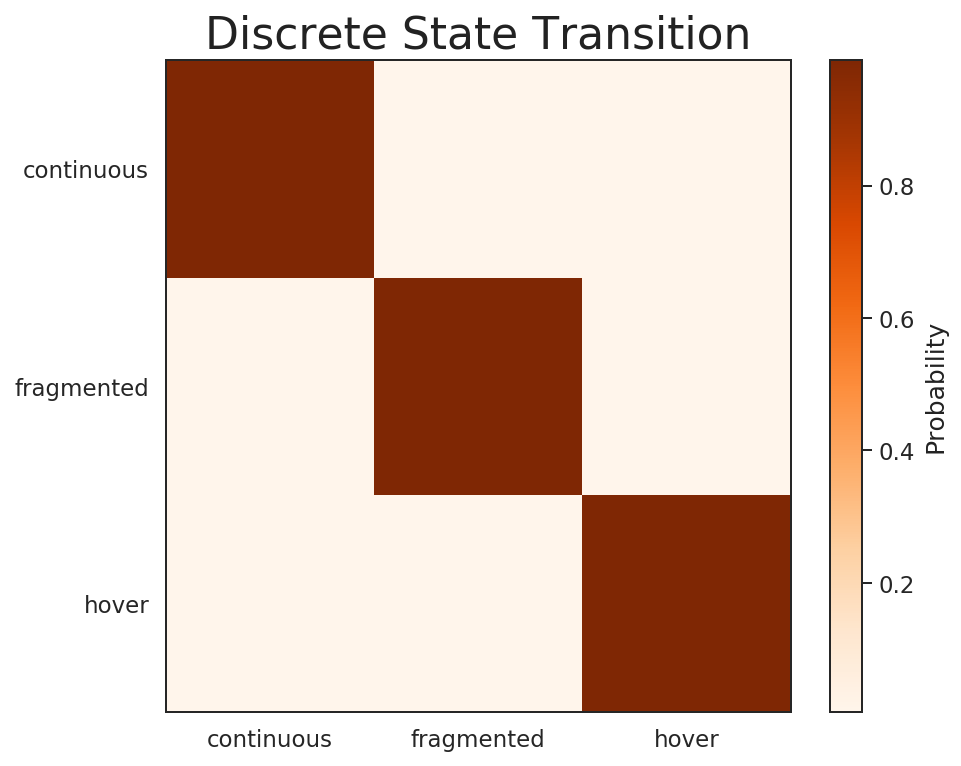

In [7]:
state_names = ['continuous', 'fragmented', 'hover']
edges = np.arange(0.5, 4.5)
x_edges, y_edges = np.meshgrid(edges, edges)
plt.figure(figsize=(7, 6))
plt.pcolormesh(x_edges, y_edges, np.fliplr(classifier.discrete_state_transition_), cmap='Oranges')
plt.xticks(ticks=range(1, 4), labels=state_names)
plt.yticks(ticks=range(1, 4), labels=state_names[::-1])
plt.colorbar(label='Probability')
plt.title('Discrete State Transition', fontsize=22);

## Test classifier on different replay types

In [8]:
def plot_classification(replay_time, test_multiunits, results):
    results = results.assign_coords(
        state=lambda ds: ds.state.to_index()
        .map(TRANSITION_TO_CATEGORY))
    fig, axes = plt.subplots(3, 1, figsize=(12, 10), constrained_layout=True, sharex=True)
    test_multiunit_spikes = np.any(~np.isnan(test_multiunits), axis=1)
    spike_time_ind, neuron_ind = np.nonzero(test_multiunit_spikes)
    axes[0].scatter(replay_time[spike_time_ind], neuron_ind, color='black')
    axes[0].set_yticks((0, test_multiunit_spikes.shape[1]))
    axes[0].set_ylabel('Tetrode Index')
    
    replay_probabilities = results.acausal_posterior.sum('position')
    for state, probability in replay_probabilities.groupby('state'):
        probability.plot(x='time', color=STATE_COLORS[state], linewidth=3, ax=axes[1])
    axes[1].set_ylabel('Probability')
    axes[1].set_ylim((0.0, 1.05))
    
    results.acausal_posterior.sum('state').plot(
            x='time', y='position', robust=True, vmin=0.0, ax=axes[2])
    plt.xlim((replay_time.min(), replay_time.max()))
    sns.despine()

### Continuous

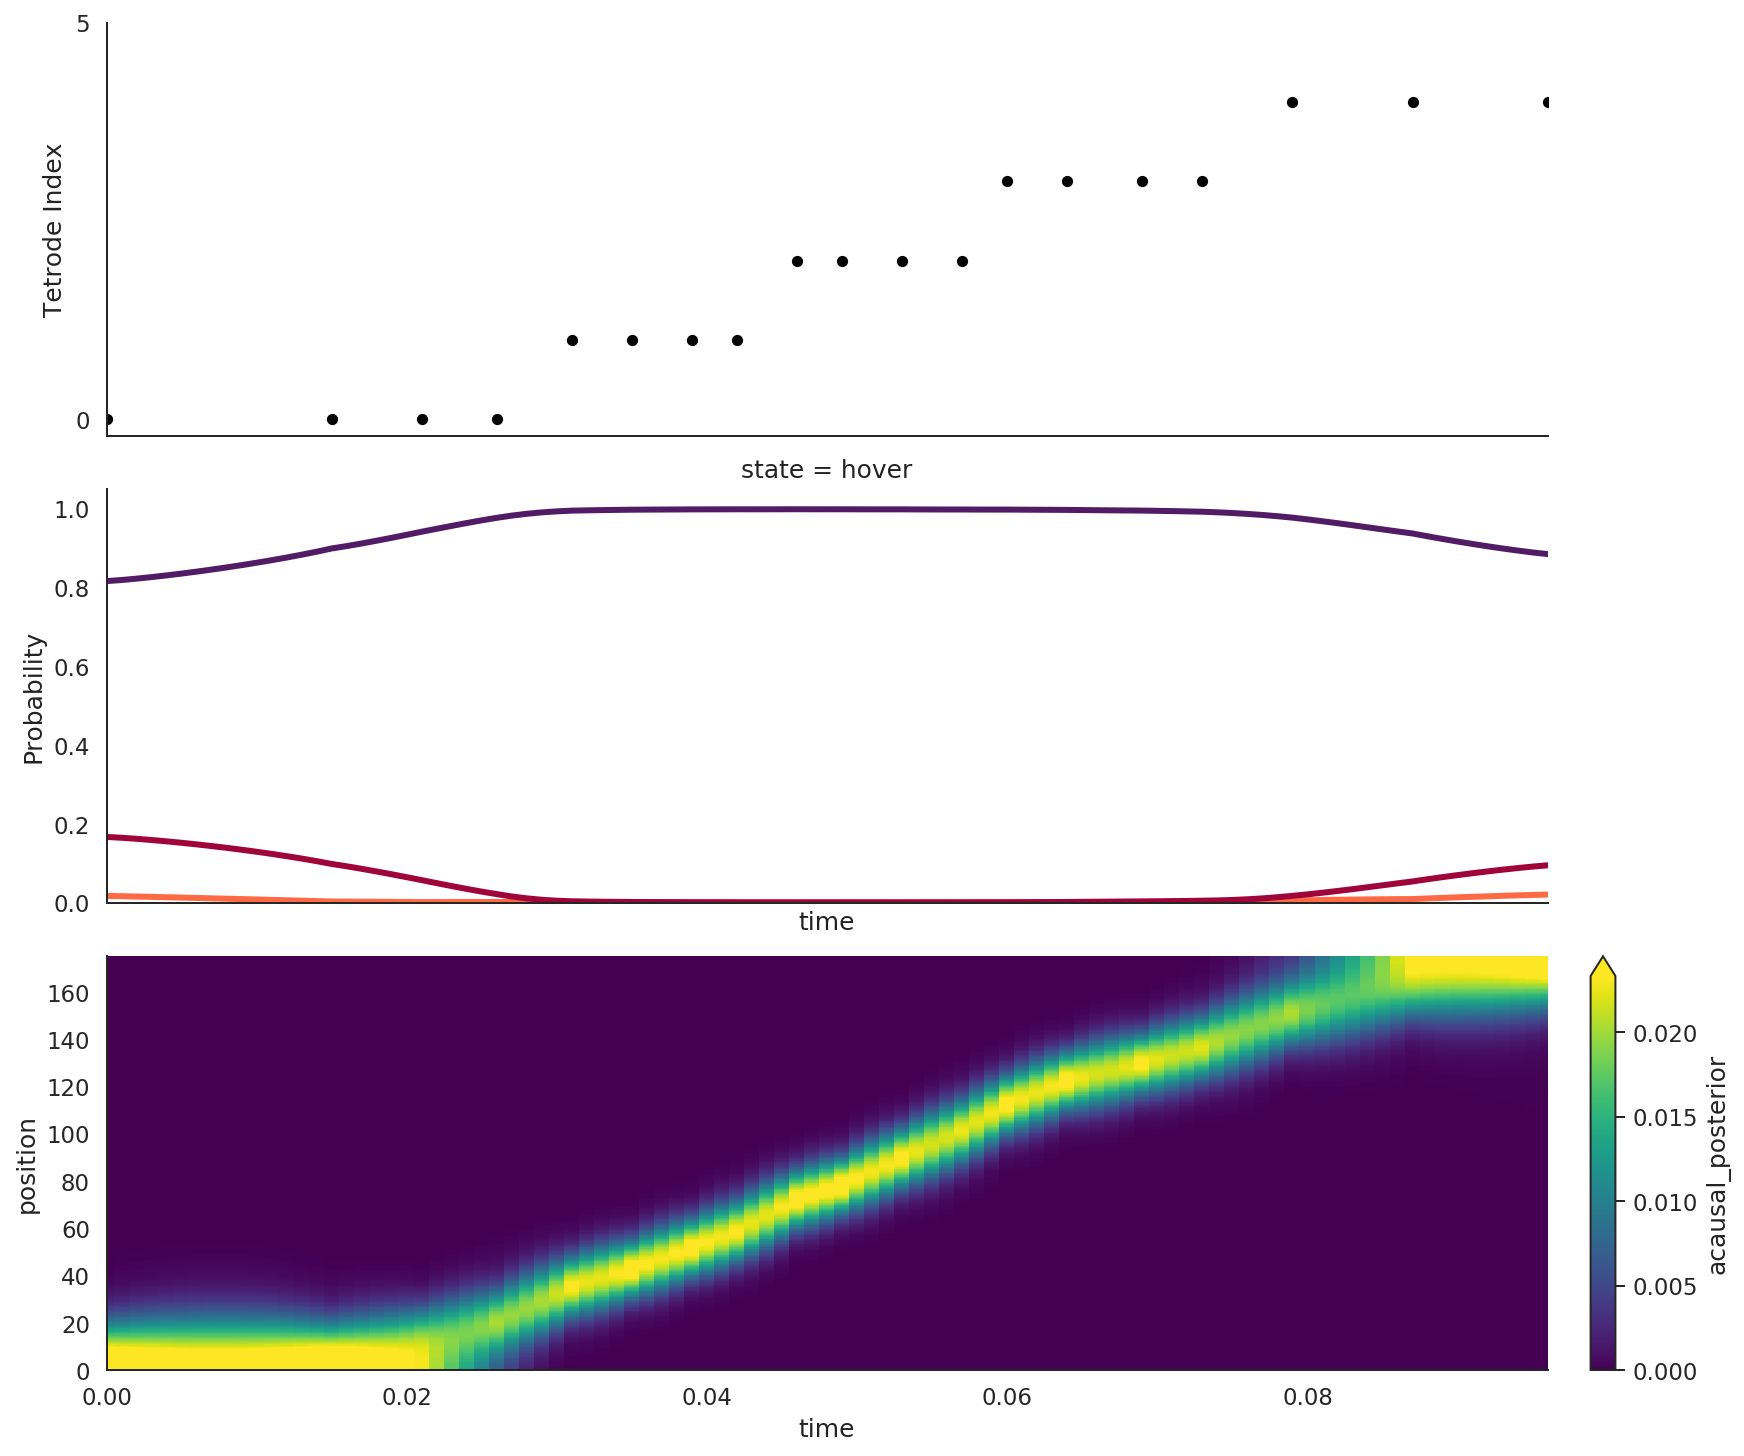

In [9]:
from replay_trajectory_classification.clusterless_simulation import make_continuous_replay

replay_time, test_multiunits = make_continuous_replay()

results = classifier.predict(test_multiunits, time=replay_time)
plot_classification(replay_time, test_multiunits, results)

### Hover

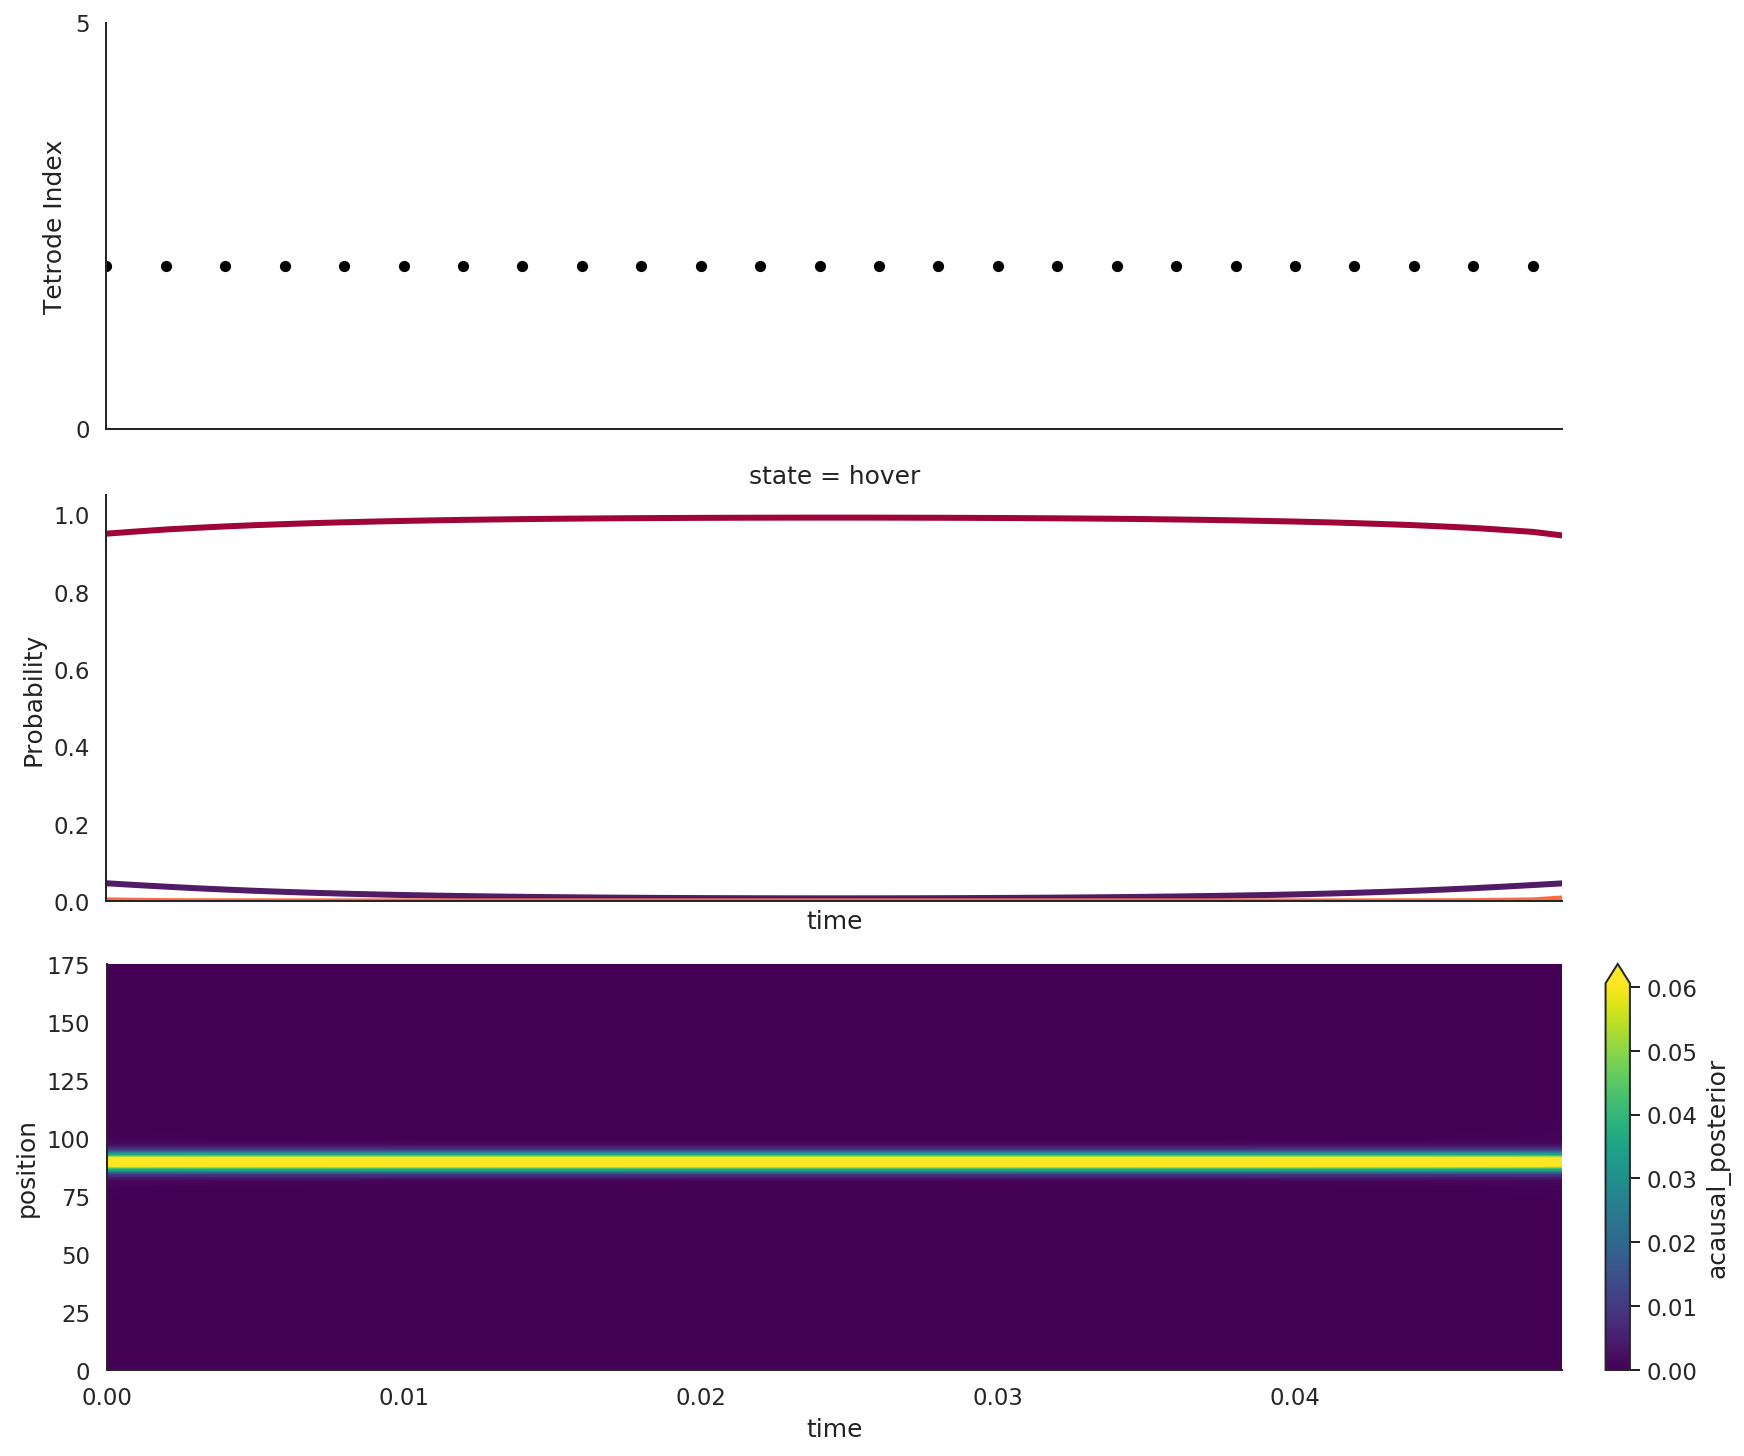

In [10]:
from replay_trajectory_classification.clusterless_simulation import make_hover_replay

replay_time, test_multiunits = make_hover_replay()

results = classifier.predict(test_multiunits, time=replay_time)
plot_classification(replay_time, test_multiunits, results)

### Fragmented

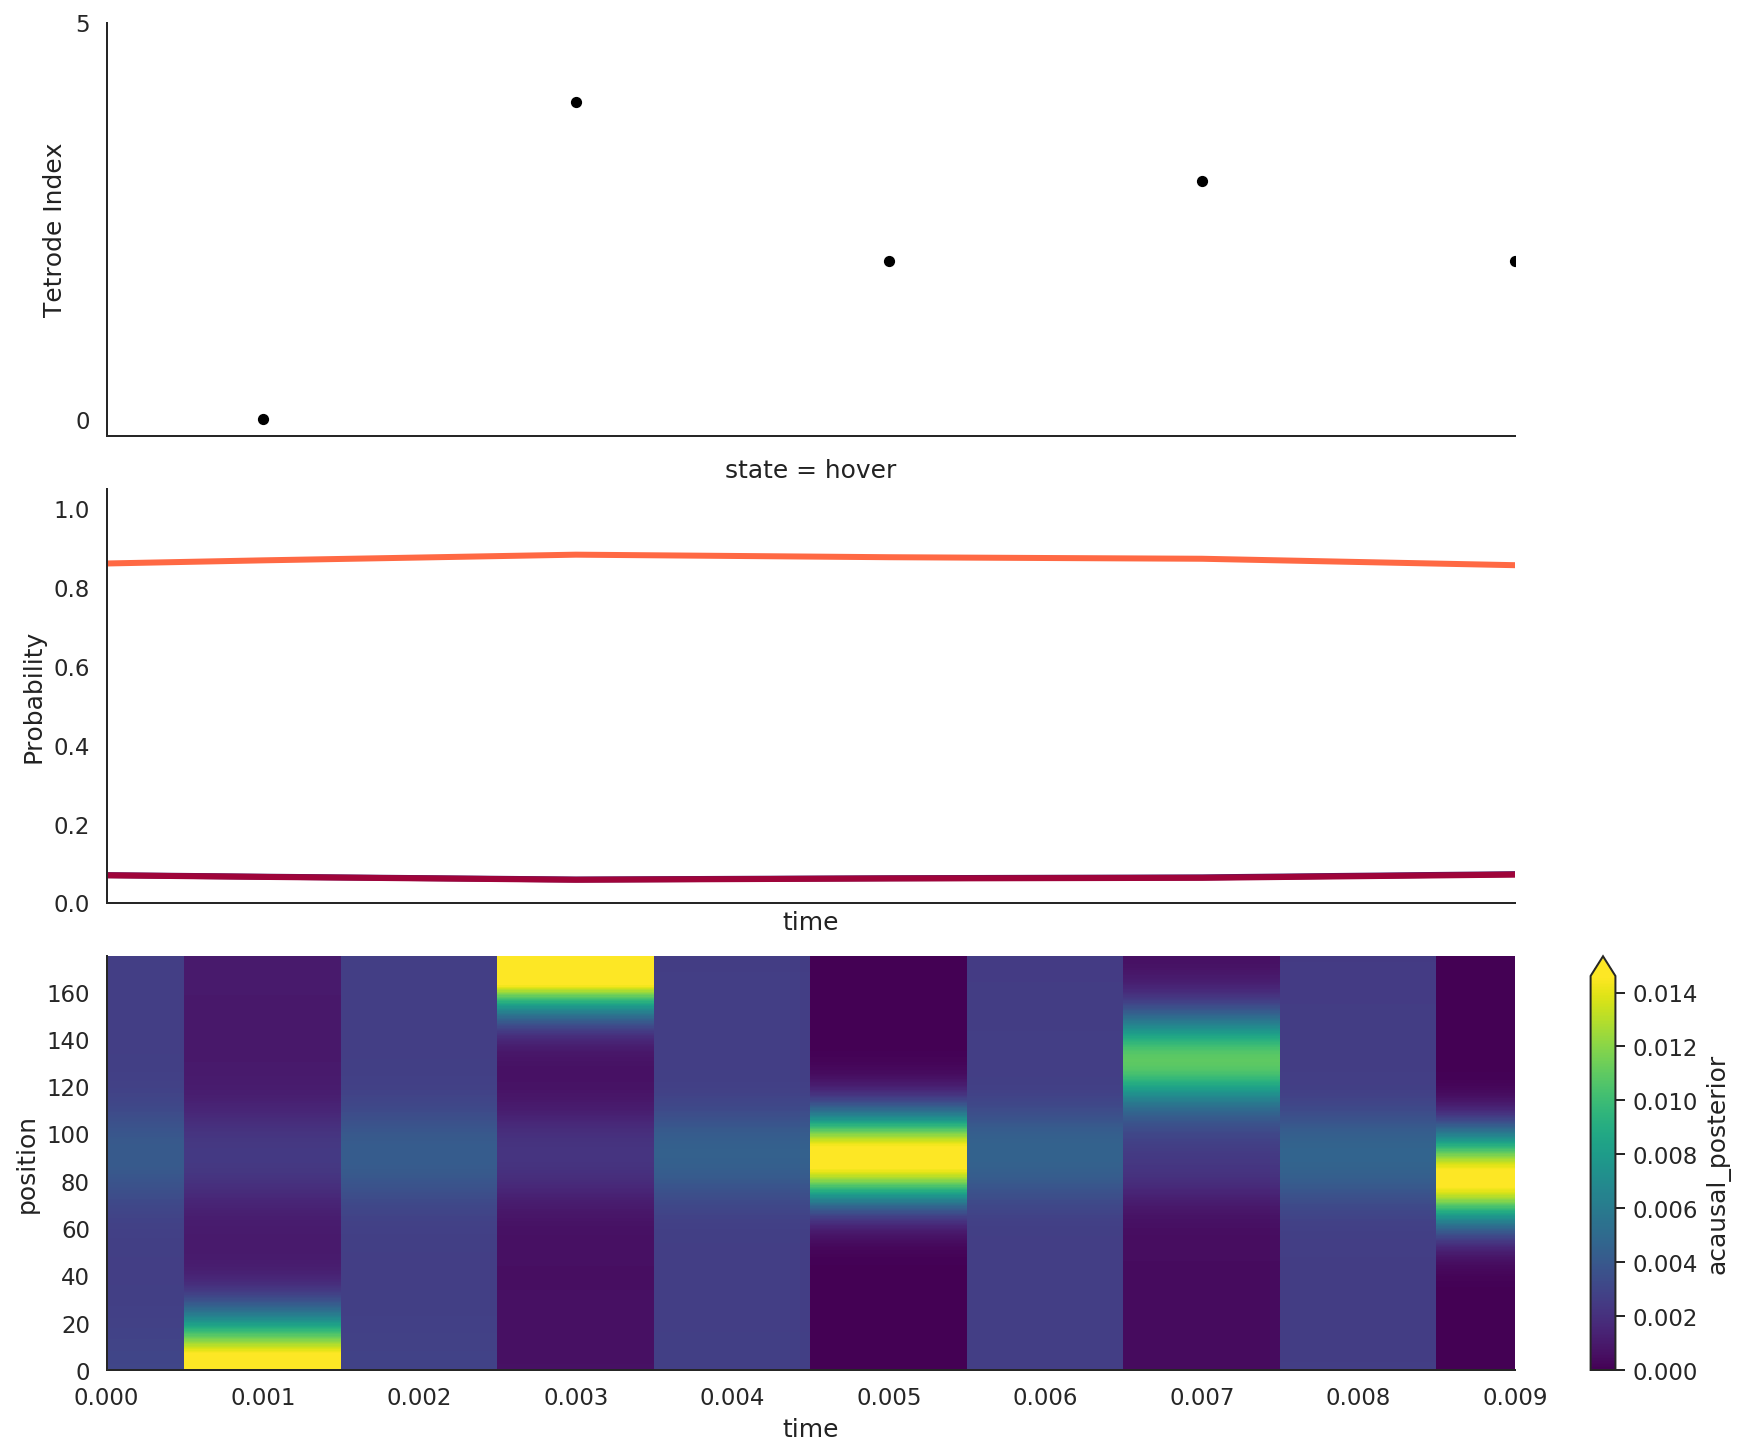

In [11]:
from replay_trajectory_classification.clusterless_simulation import make_fragmented_replay

replay_time, test_multiunits = make_fragmented_replay()

results = classifier.predict(test_multiunits, time=replay_time)
plot_classification(replay_time, test_multiunits, results)

### Hover-Continuous-Hover 

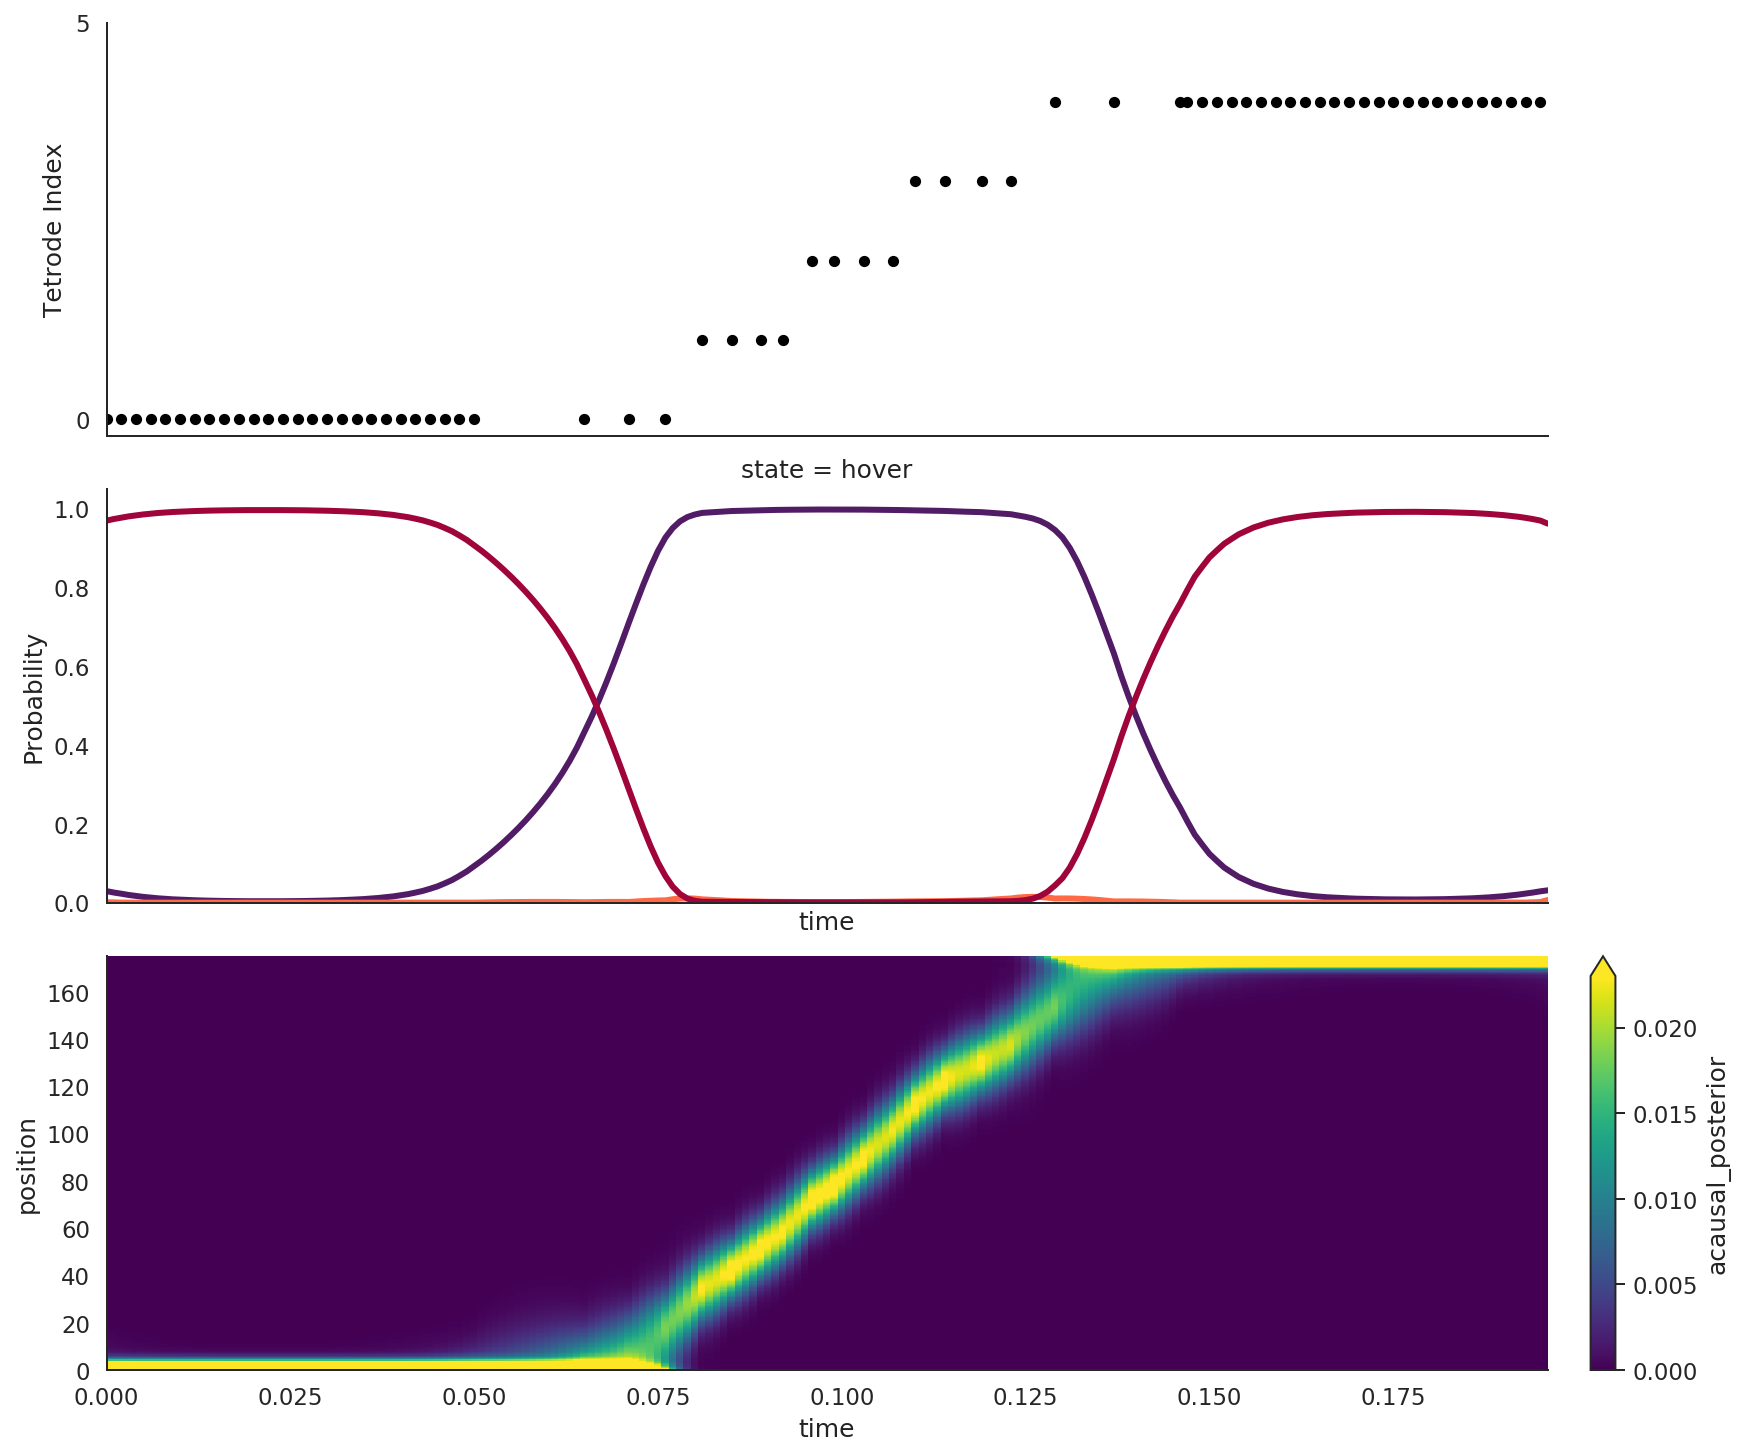

In [12]:
from replay_trajectory_classification.clusterless_simulation import make_hover_continuous_hover_replay

replay_time, test_multiunits = make_hover_continuous_hover_replay()

results = classifier.predict(test_multiunits, time=replay_time)
plot_classification(replay_time, test_multiunits, results)

### Fragmented-Hover-Fragmented

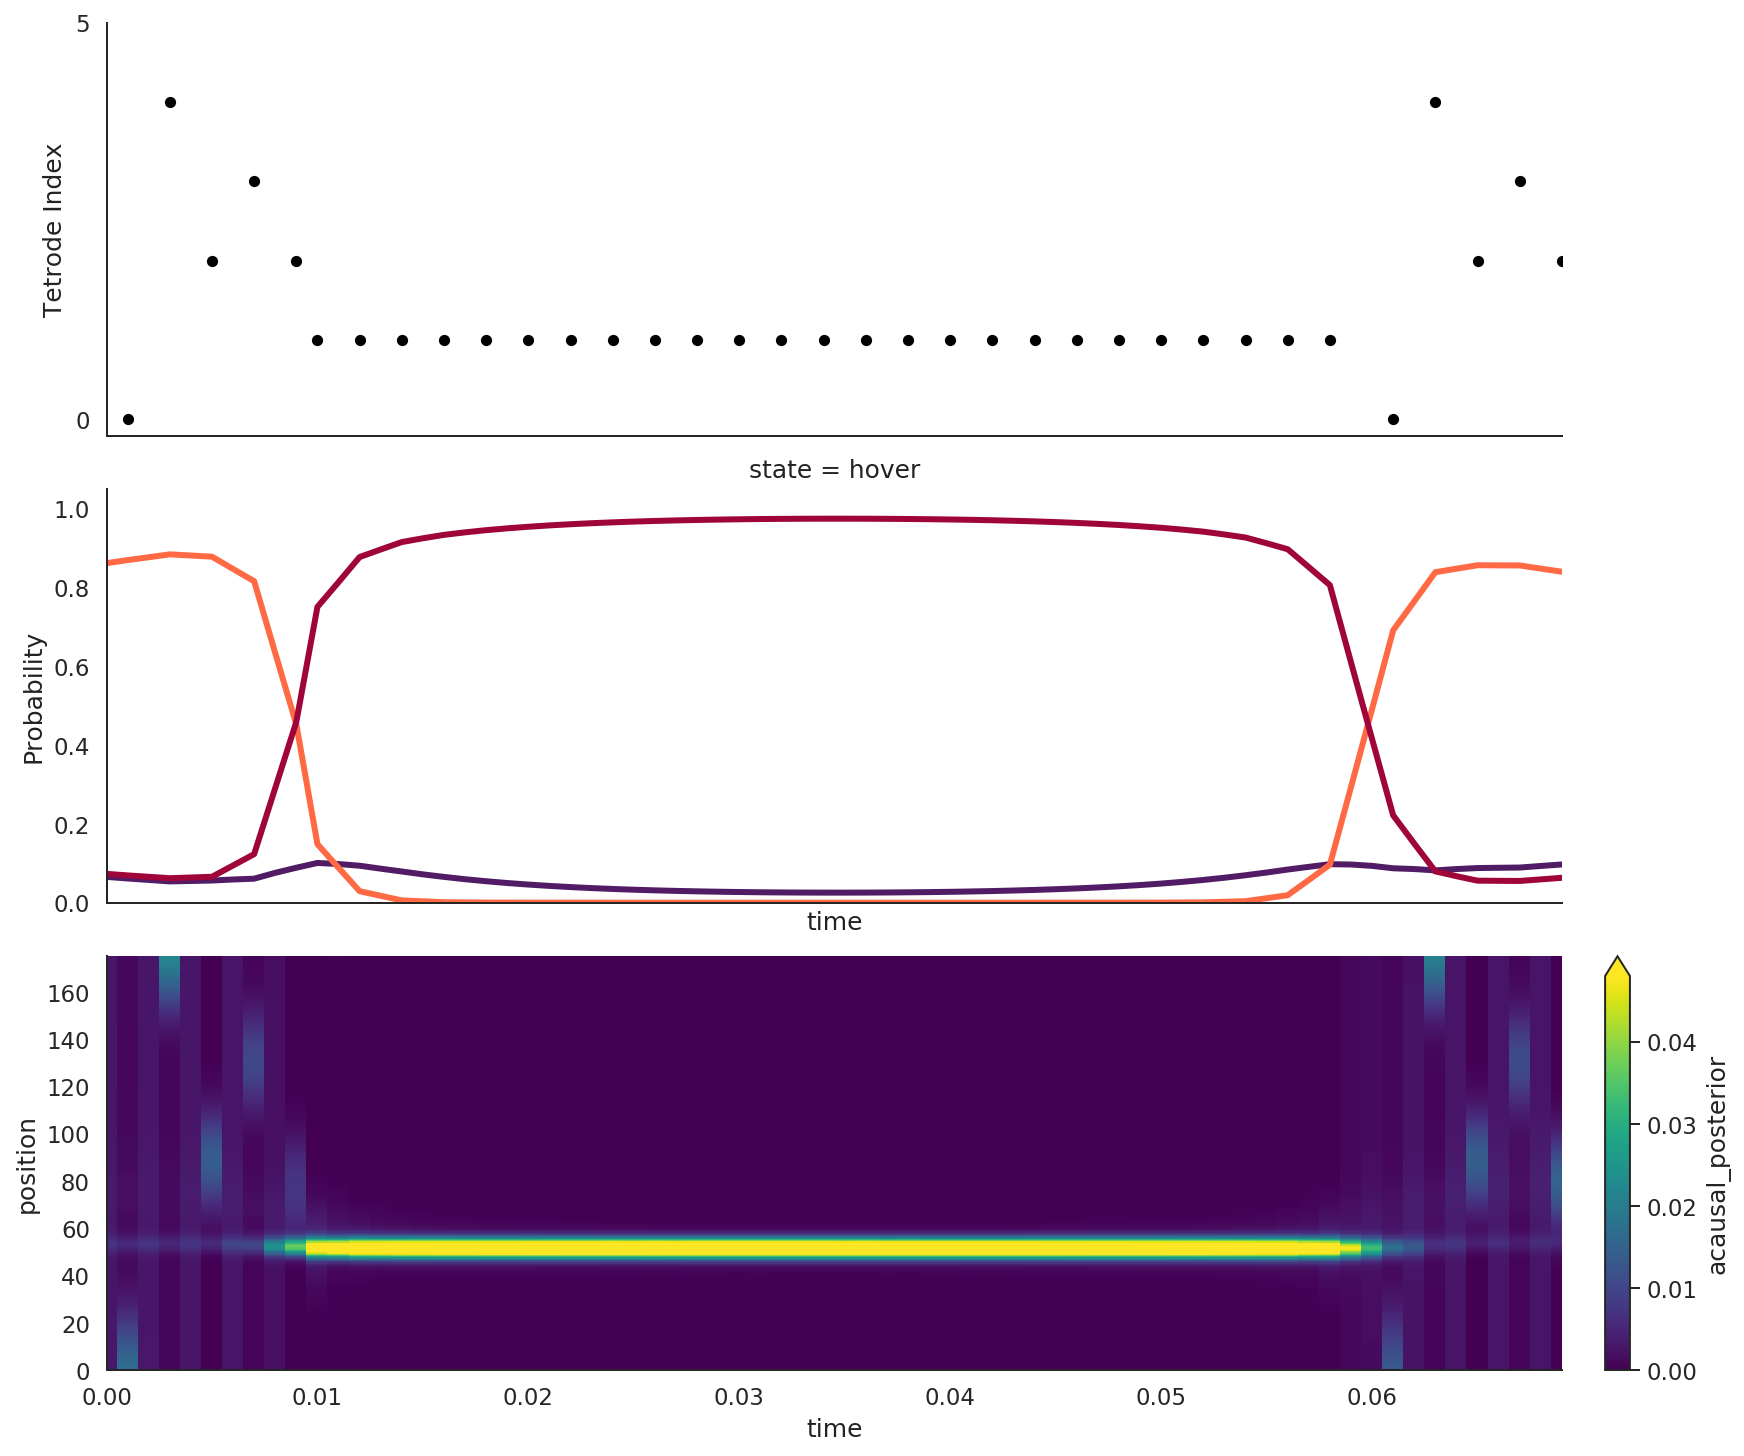

In [13]:
from replay_trajectory_classification.clusterless_simulation import make_fragmented_hover_fragmented_replay

replay_time, test_multiunits = make_fragmented_hover_fragmented_replay()

results = classifier.predict(test_multiunits, time=replay_time)
plot_classification(replay_time, test_multiunits, results)

### Fragmented-Continuous-Fragmented

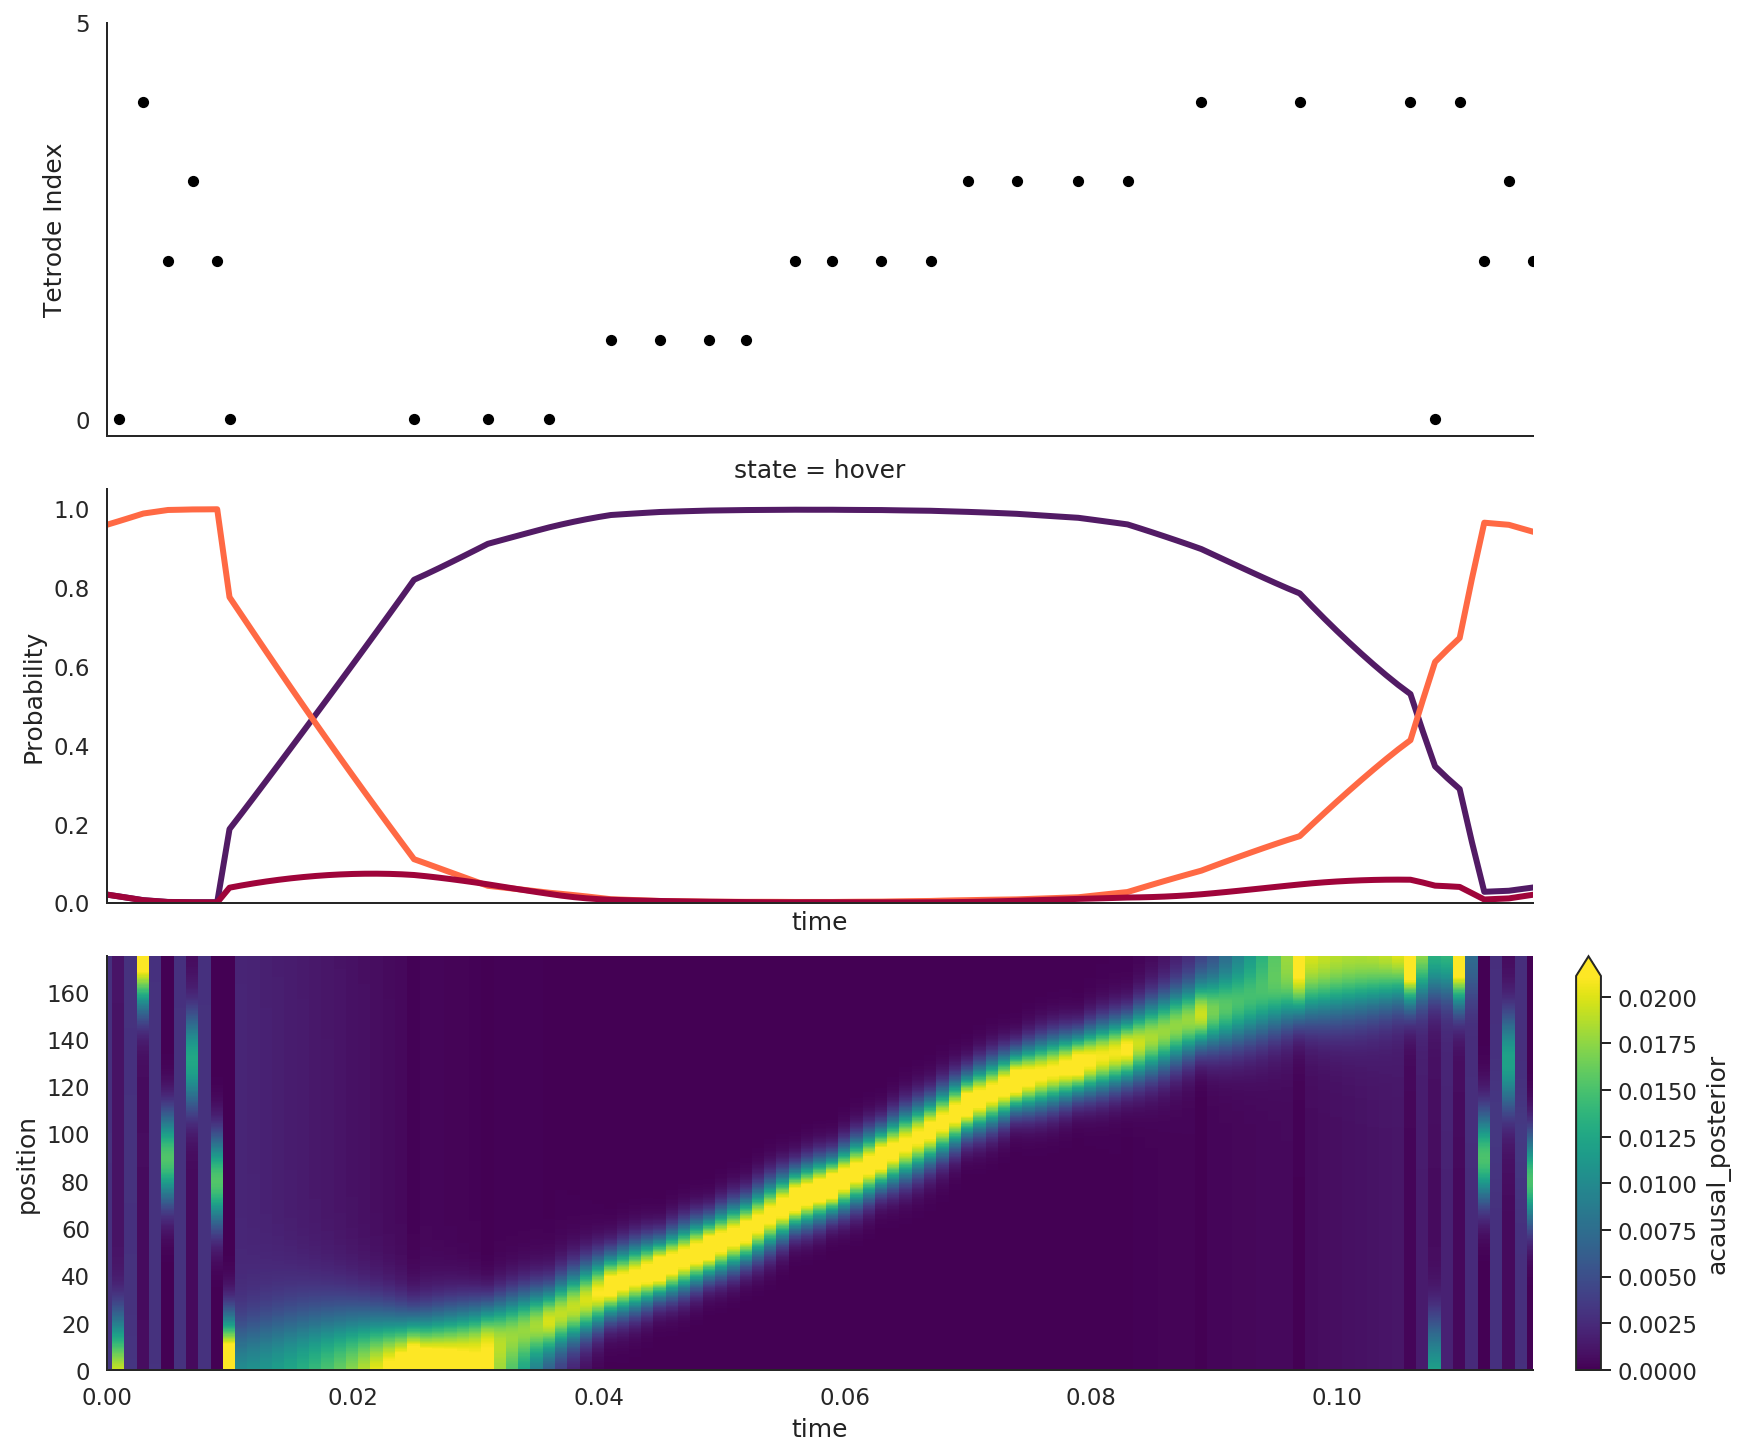

In [14]:
from replay_trajectory_classification.clusterless_simulation import make_fragmented_continuous_fragmented_replay

replay_time, test_multiunits = make_fragmented_continuous_fragmented_replay()

results = classifier.predict(test_multiunits, time=replay_time)
plot_classification(replay_time, test_multiunits, results)

## Explore State Transition Parameters on Hover-Continuous-Hover

In [15]:
from replay_trajectory_classification.clusterless_simulation import make_hover_continuous_hover_replay

replay_time, test_multiunits = make_hover_continuous_hover_replay()

def plot_replay_probability(replay_time, results, diag):
    results = results.assign_coords(
        state=lambda ds: ds.state.to_index()
        .map(TRANSITION_TO_CATEGORY))
    fig, ax = plt.subplots(1, 1, figsize=(10, 3), constrained_layout=True, sharex=True)
    replay_probabilities = results.acausal_posterior.sum('position')
    for state, probability in replay_probabilities.groupby('state'):
        probability.plot(x='time', color=STATE_COLORS[state], linewidth=3, ax=ax)
    plt.xlim((replay_time.min(), replay_time.max()))
    plt.ylabel('Probability')
    plt.ylim((0.0, 1.05))
    plt.title(f'discrete state transition diagonal = {diag}', fontsize=16)
    sns.despine()

### All states equally likely

INFO:replay_trajectory_classification.classifier:Fitting initial conditions...
INFO:replay_trajectory_classification.classifier:Fitting state transition...
INFO:replay_trajectory_classification.classifier:Fitting multiunits...


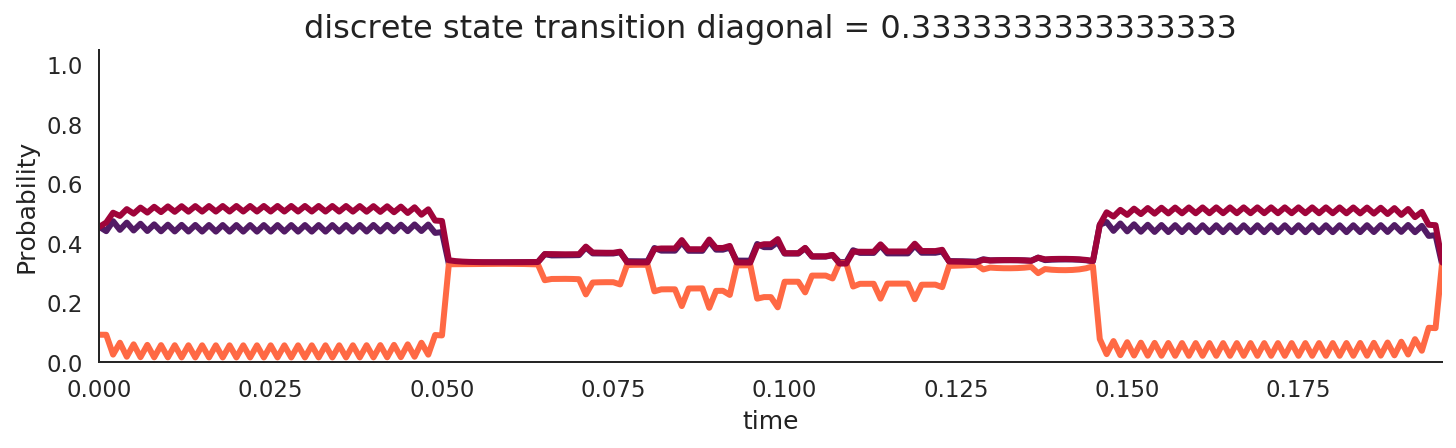

In [16]:
diag = 1/3

classifier = ClusterlessClassifier(movement_var=movement_var,
                                   replay_speed=120,
                                   place_bin_size=np.sqrt(movement_var),
                                   model=model,
                                   model_kwargs=model_kwargs,
                                   discrete_transition_diag=diag)
classifier.fit(linear_distance, multiunits)

results = classifier.predict(test_multiunits, time=replay_time)
plot_replay_probability(replay_time, results, diag)

### Test diagonal strength from 0.4 - 0.9

INFO:replay_trajectory_classification.classifier:Fitting initial conditions...
INFO:replay_trajectory_classification.classifier:Fitting state transition...
INFO:replay_trajectory_classification.classifier:Fitting multiunits...
INFO:replay_trajectory_classification.classifier:Fitting initial conditions...
INFO:replay_trajectory_classification.classifier:Fitting state transition...
INFO:replay_trajectory_classification.classifier:Fitting multiunits...
INFO:replay_trajectory_classification.classifier:Fitting initial conditions...
INFO:replay_trajectory_classification.classifier:Fitting state transition...
INFO:replay_trajectory_classification.classifier:Fitting multiunits...
INFO:replay_trajectory_classification.classifier:Fitting initial conditions...
INFO:replay_trajectory_classification.classifier:Fitting state transition...
INFO:replay_trajectory_classification.classifier:Fitting multiunits...
INFO:replay_trajectory_classification.classifier:Fitting initial conditions...
INFO:replay_t

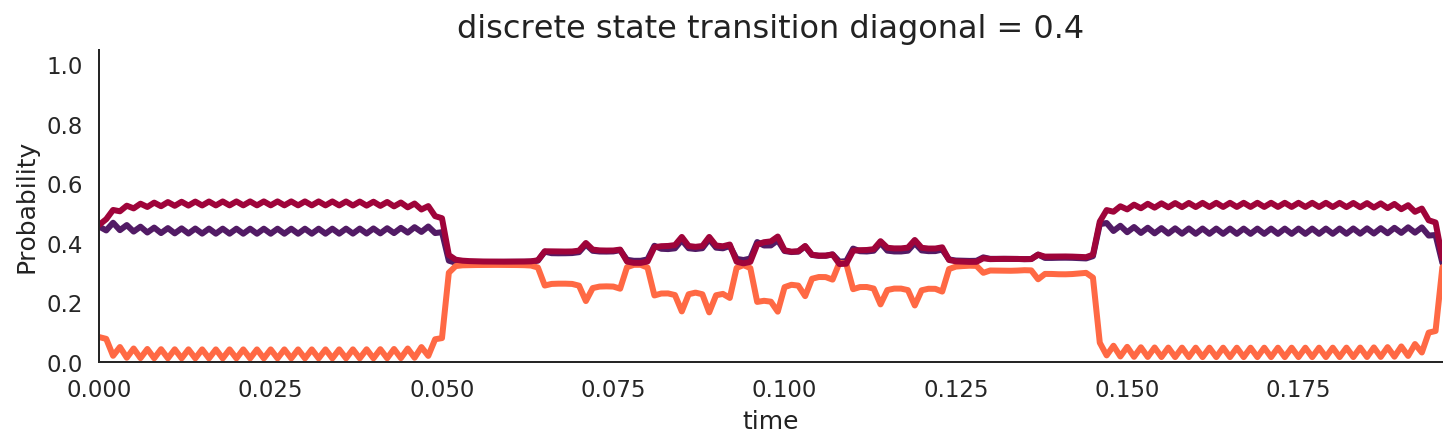

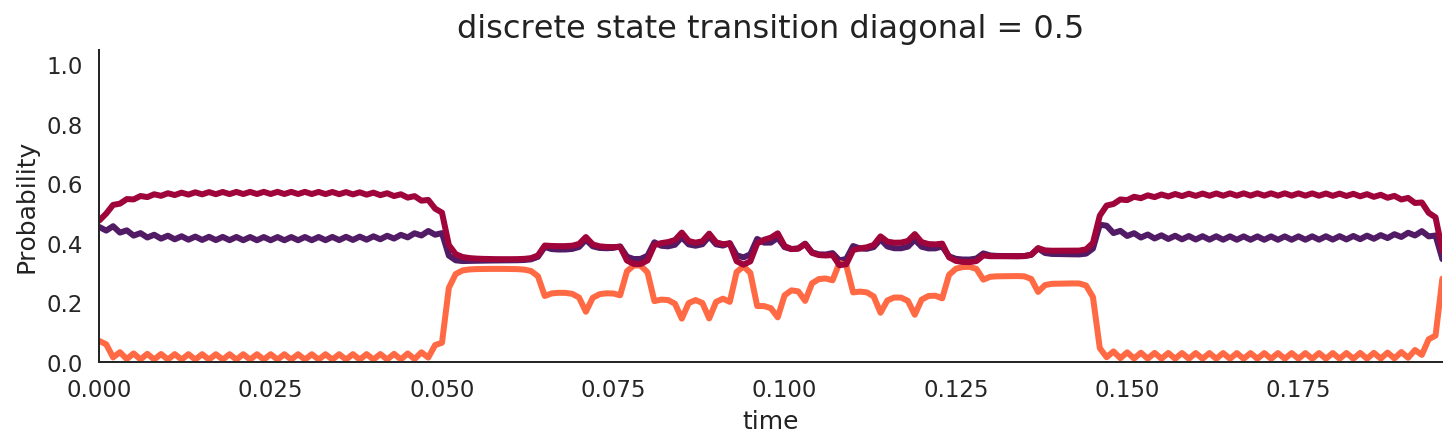

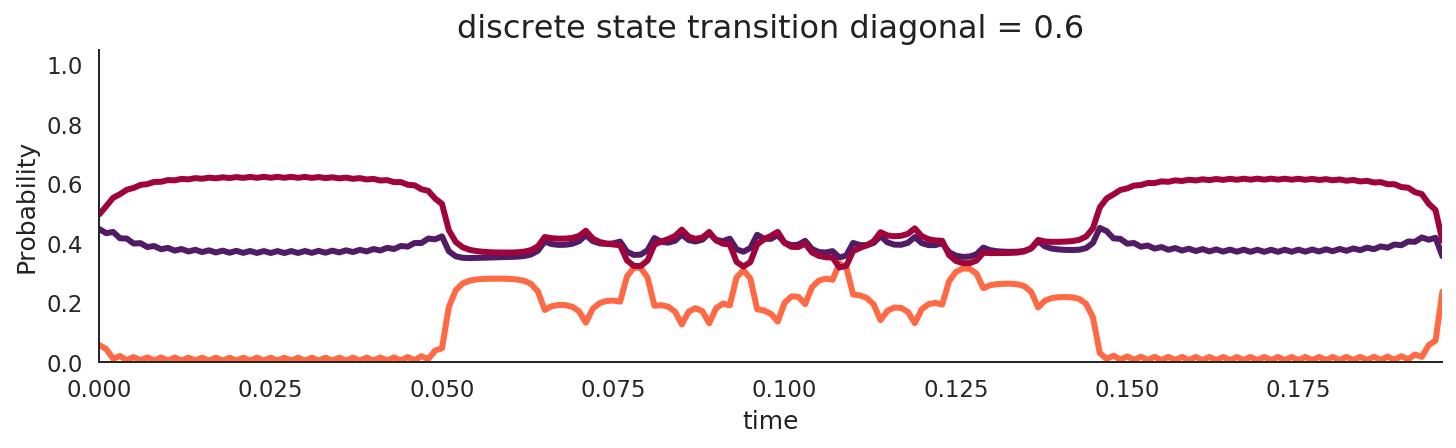

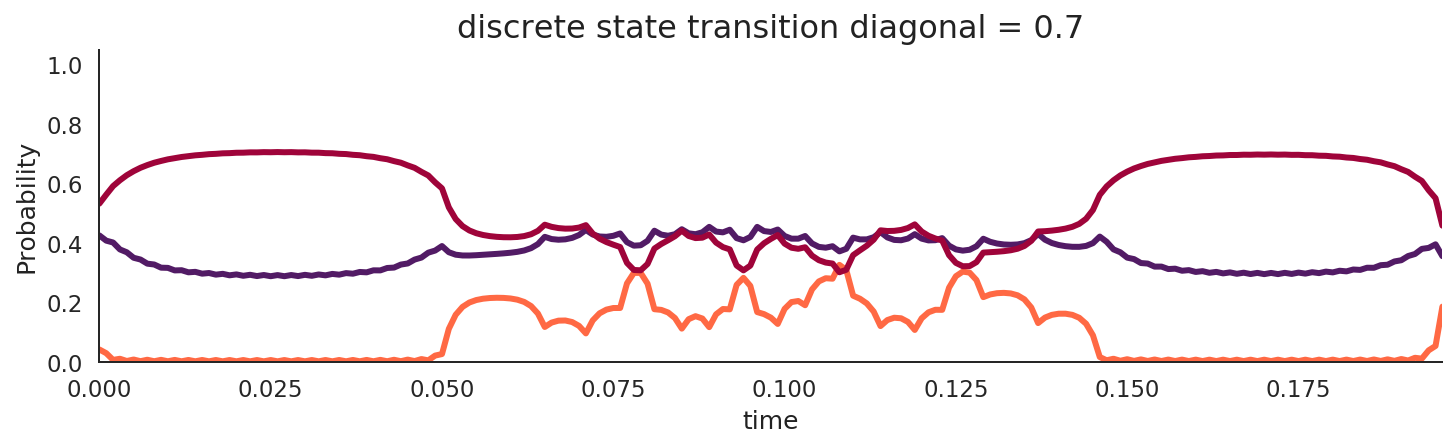

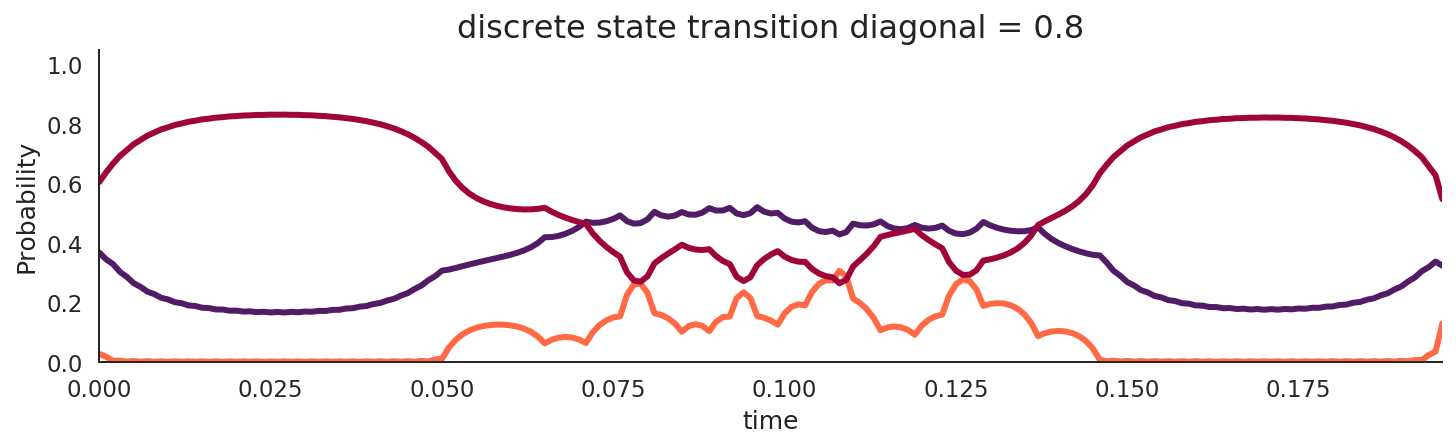

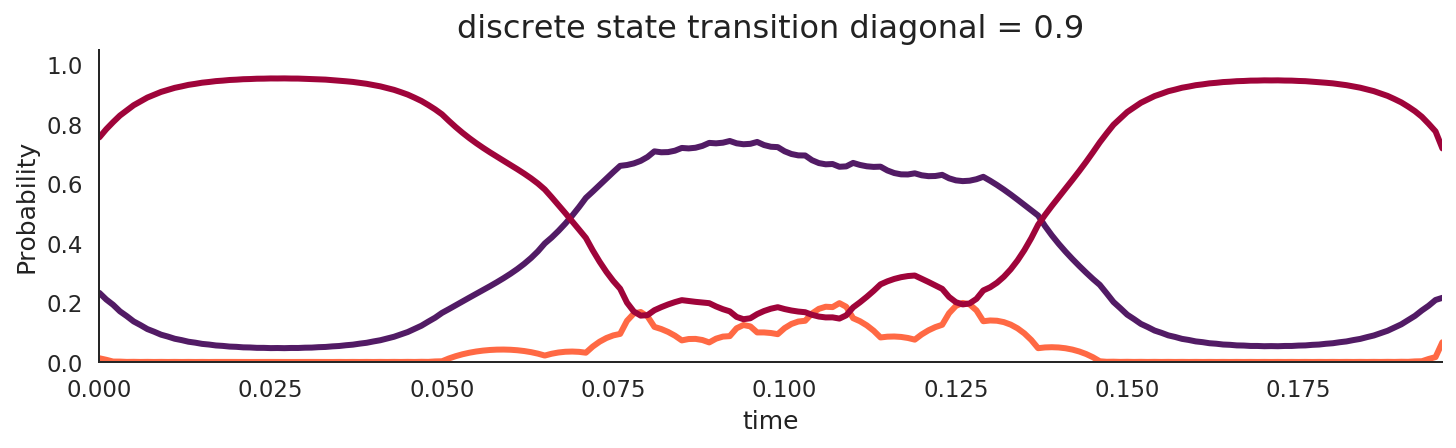

In [17]:
diags = [0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

for diag in diags:
    classifier = ClusterlessClassifier(movement_var=movement_var,
                                       replay_speed=120,
                                       place_bin_size=np.sqrt(movement_var),
                                       model=model,
                                       model_kwargs=model_kwargs,
                                       discrete_transition_diag=diag)
    classifier.fit(linear_distance, multiunits)

    results = classifier.predict(test_multiunits, time=replay_time)
    plot_replay_probability(replay_time, results, diag)

### Test diagonal strength from 0.99 - 0.999999999

INFO:replay_trajectory_classification.classifier:Fitting initial conditions...
INFO:replay_trajectory_classification.classifier:Fitting state transition...
INFO:replay_trajectory_classification.classifier:Fitting multiunits...
INFO:replay_trajectory_classification.classifier:Fitting initial conditions...
INFO:replay_trajectory_classification.classifier:Fitting state transition...
INFO:replay_trajectory_classification.classifier:Fitting multiunits...
INFO:replay_trajectory_classification.classifier:Fitting initial conditions...
INFO:replay_trajectory_classification.classifier:Fitting state transition...
INFO:replay_trajectory_classification.classifier:Fitting multiunits...
INFO:replay_trajectory_classification.classifier:Fitting initial conditions...
INFO:replay_trajectory_classification.classifier:Fitting state transition...
INFO:replay_trajectory_classification.classifier:Fitting multiunits...
INFO:replay_trajectory_classification.classifier:Fitting initial conditions...
INFO:replay_t

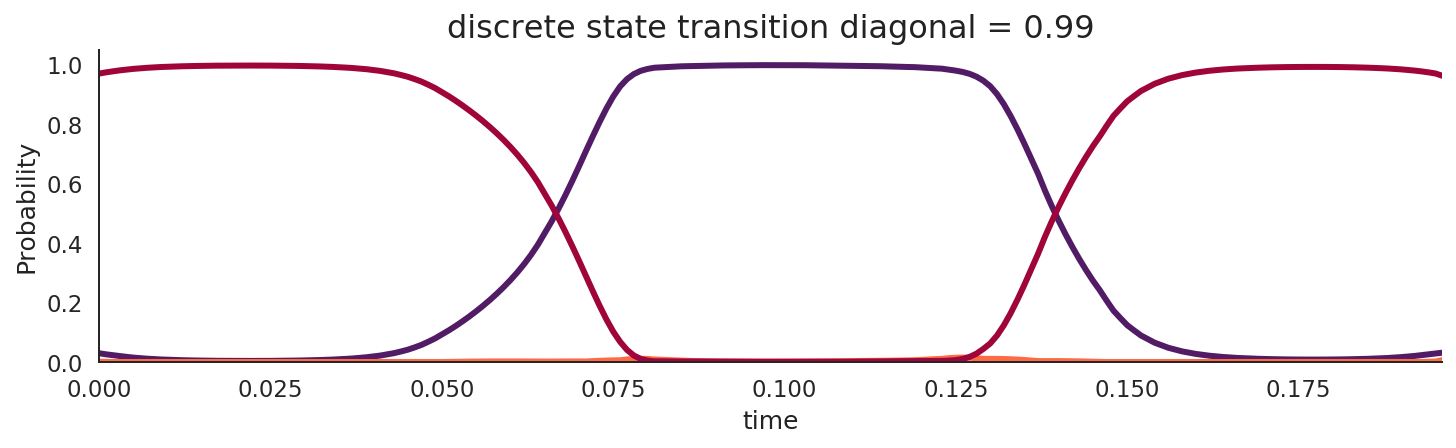

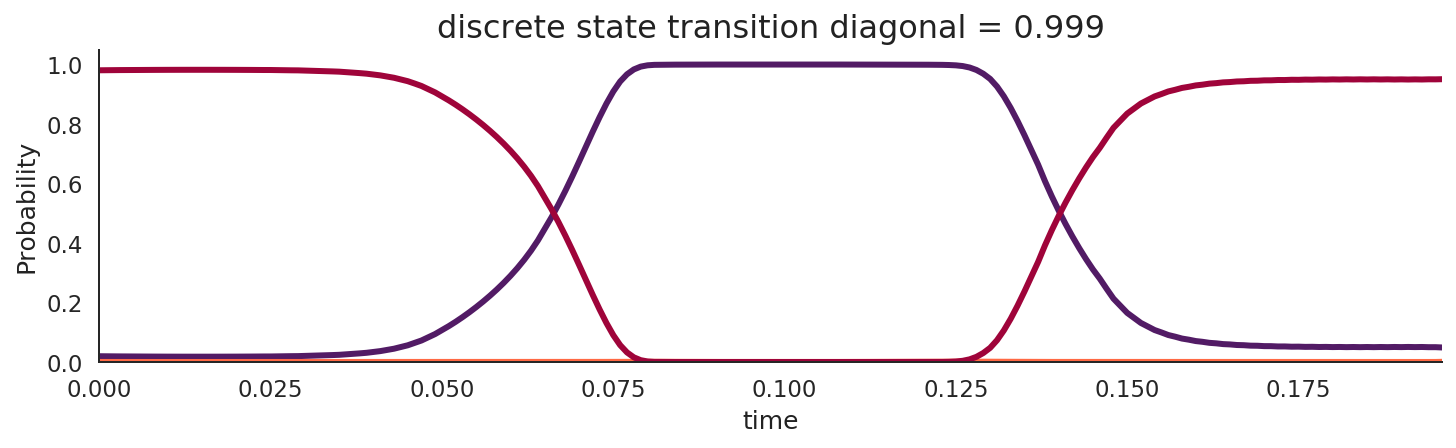

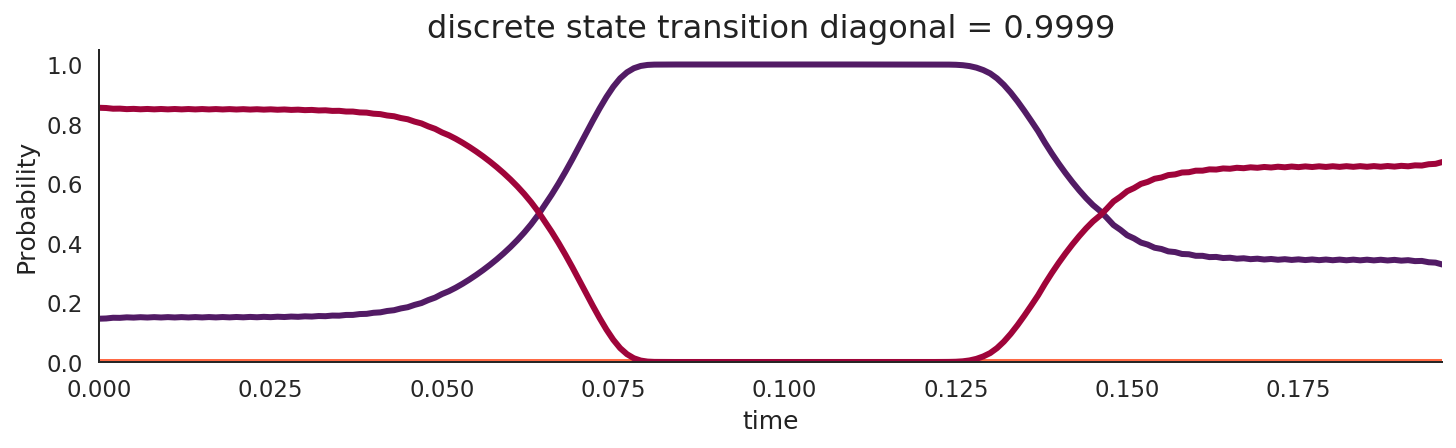

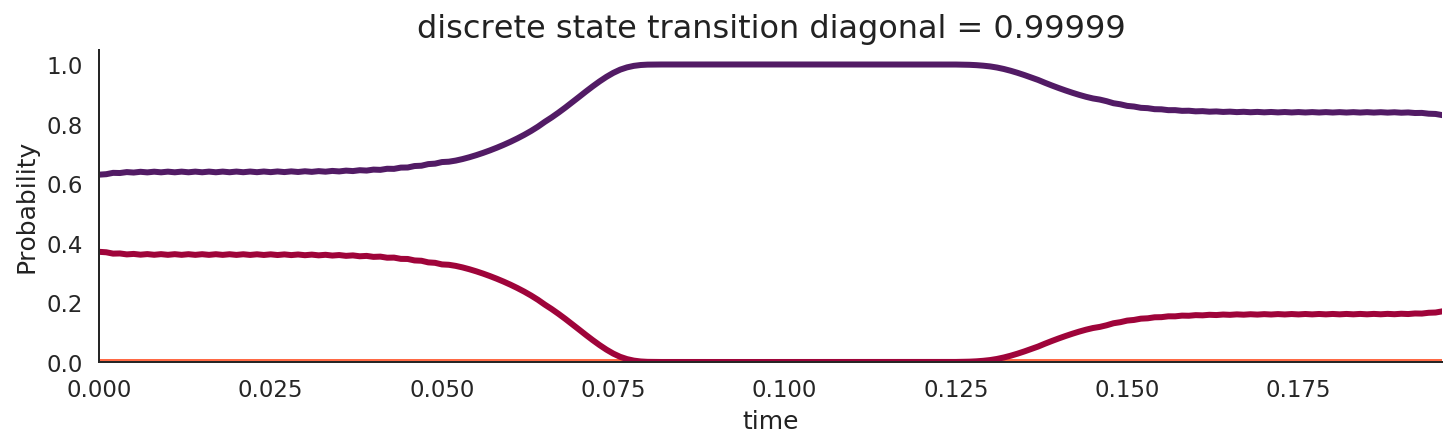

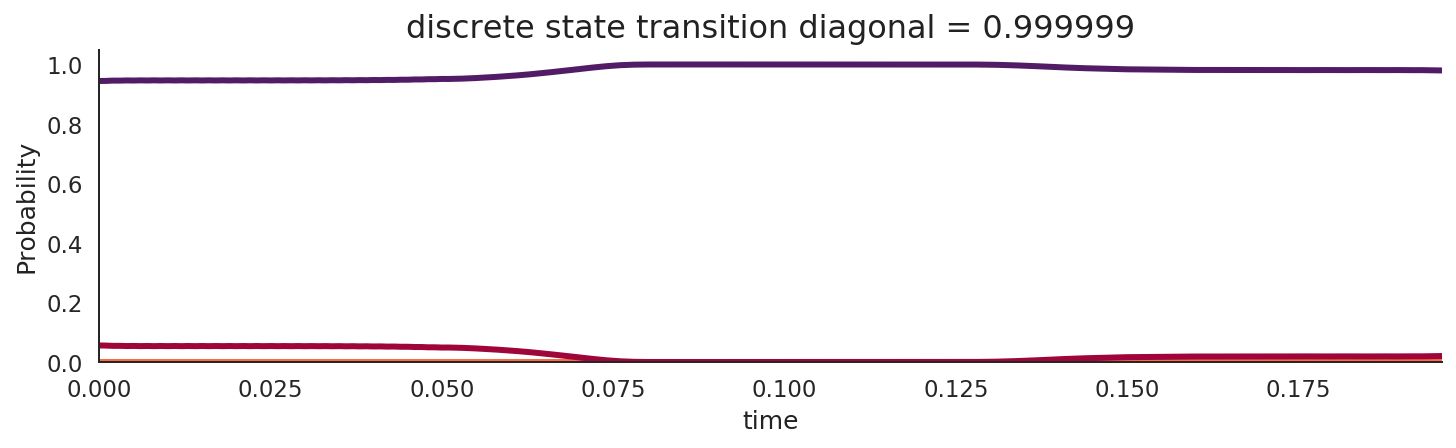

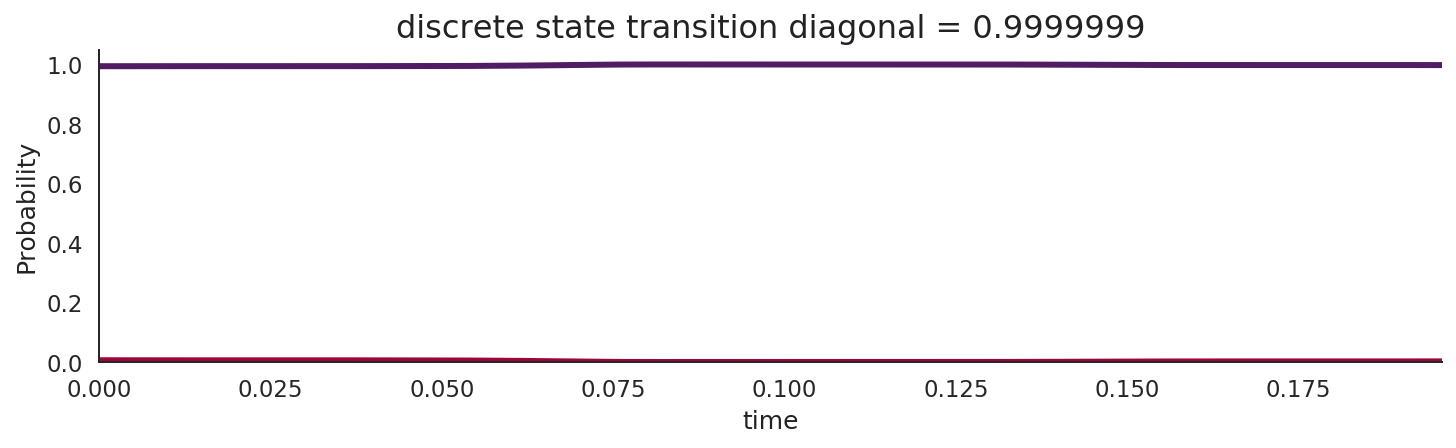

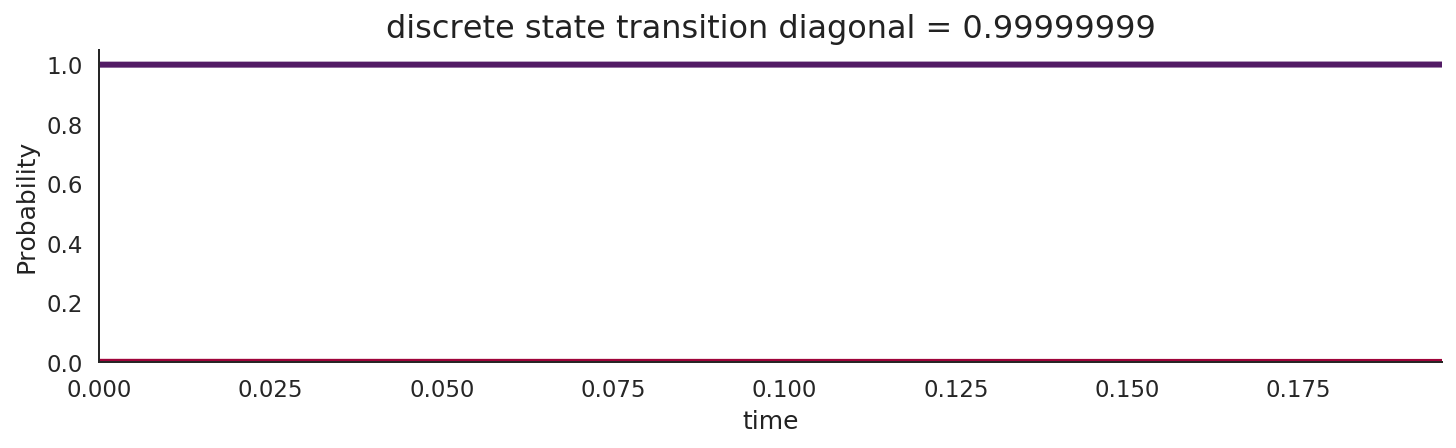

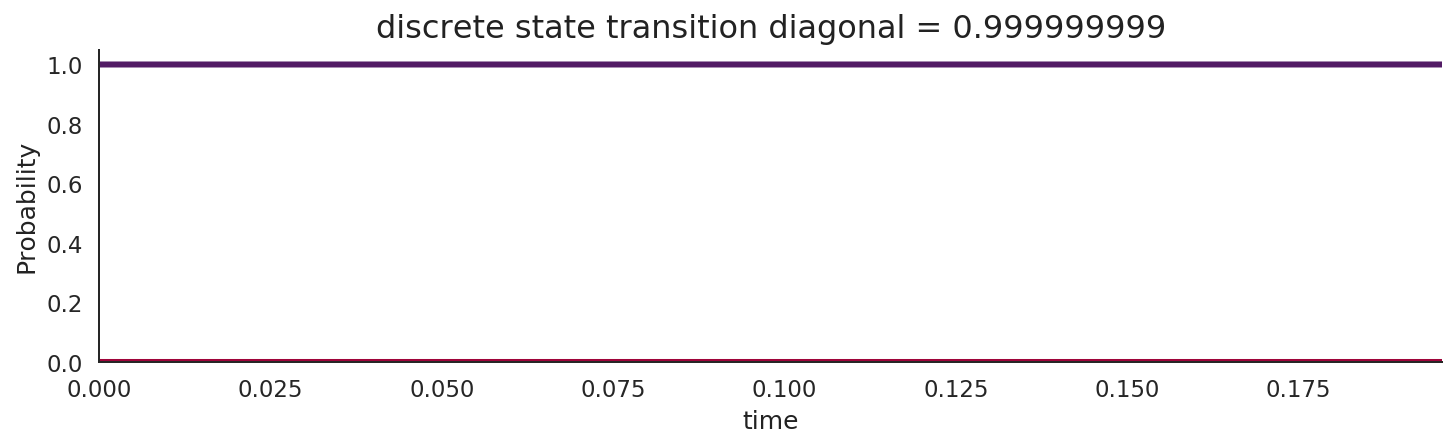

In [18]:
diags = [(1 - 10 ** -n) for n in range(2, 10)]

for diag in diags:
    classifier = ClusterlessClassifier(movement_var=movement_var,
                                       replay_speed=120,
                                       place_bin_size=np.sqrt(movement_var),
                                       model=model,
                                       model_kwargs=model_kwargs,
                                       discrete_transition_diag=diag)
    classifier.fit(linear_distance, multiunits)

    results = classifier.predict(test_multiunits, time=replay_time)
    plot_replay_probability(replay_time, results, diag)

### Not allowing transitions between states

INFO:replay_trajectory_classification.classifier:Fitting initial conditions...
INFO:replay_trajectory_classification.classifier:Fitting state transition...
INFO:replay_trajectory_classification.classifier:Fitting multiunits...


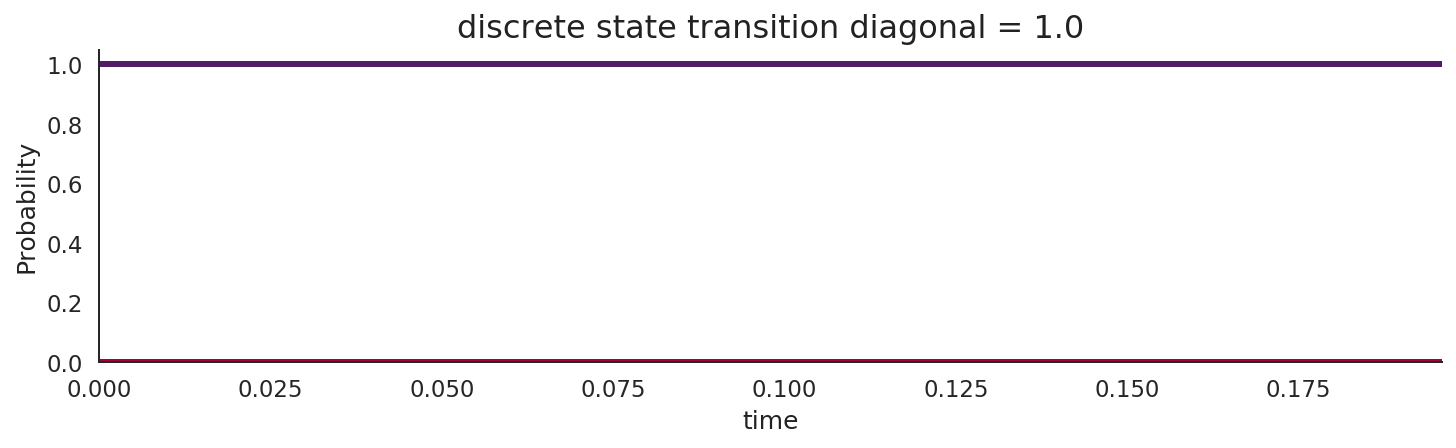

In [19]:
diag = 1.0

classifier = ClusterlessClassifier(movement_var=movement_var,
                                   replay_speed=120,
                                   place_bin_size=np.sqrt(movement_var),
                                   model=model,
                                   model_kwargs=model_kwargs,
                                   discrete_transition_diag=diag)
classifier.fit(linear_distance, multiunits)

results = classifier.predict(test_multiunits, time=replay_time)
plot_replay_probability(replay_time, results, diag)